In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.api import OLS
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
from utils.regression import (
    plot_data, get_data, get_data_for_MLP, # data functions
    backward_elimination, # linear regression function
    plot_regression_2D, plot_regression_1D, plot_regression_1D_all, summary, plot_stats_neurons # plotting functions
)

# VISam - Neurons Selected by Variance (80th percentile)

In [2]:
df = pd.read_csv("data/static_gratings_VISam_var_80_6neurons.csv")
df

unit_id  spike_count  orientation  phase  spatial_frequency
0    951092940          282        150.0   0.50               0.02
1    951093080          390        150.0   0.50               0.02
2    951093283          267        150.0   0.50               0.02
3    951093608          281        150.0   0.50               0.02
4    951093928           35        150.0   0.50               0.02
..         ...          ...          ...    ...                ...
721  951093080          370         90.0   0.25               0.02
722  951093283          294         90.0   0.25               0.02
723  951093608          157         90.0   0.25               0.02
724  951093928           33         90.0   0.25               0.02
725  951098242           29         90.0   0.25               0.02

[726 rows x 5 columns]

In [3]:
df["unit_id"].unique()

array([951092940, 951093080, 951093283, 951093608, 951093928, 951098242],
      dtype=int64)

Here we include 6 neurons in the selection because we notice that unit 951092940 was also present in the neurons selected by range. We will not repeat the regression again on that, but on the other ones. This ensures that we try 5 different units in each selection type.

In [4]:
df.drop(df[df["unit_id"] == 951092940].index, inplace=True)

In [5]:
print(df["phase"].unique())
print(df["spatial_frequency"].unique())
print(df["orientation"].unique())

[0.5  0.25 0.75 0.    nan]
[0.02 0.16 0.04 0.08 0.32  nan]
[150.   0.  30.  60.  90. 120.  nan]


In [6]:
df[df.isna().any(axis=1)]

unit_id  spike_count  orientation  phase  spatial_frequency
253  951093080         1571          NaN    NaN                NaN
254  951093283          848          NaN    NaN                NaN
255  951093608          778          NaN    NaN                NaN
256  951093928          175          NaN    NaN                NaN
257  951098242          191          NaN    NaN                NaN

In [7]:
df.dropna(inplace=True)

In [8]:
# separate dataset for each neuron
dfs = {}
for i, id in enumerate(df["unit_id"].unique()):
    dfs[i] = df[df["unit_id"] == id]

Neuron 1, Number of Samples: 120


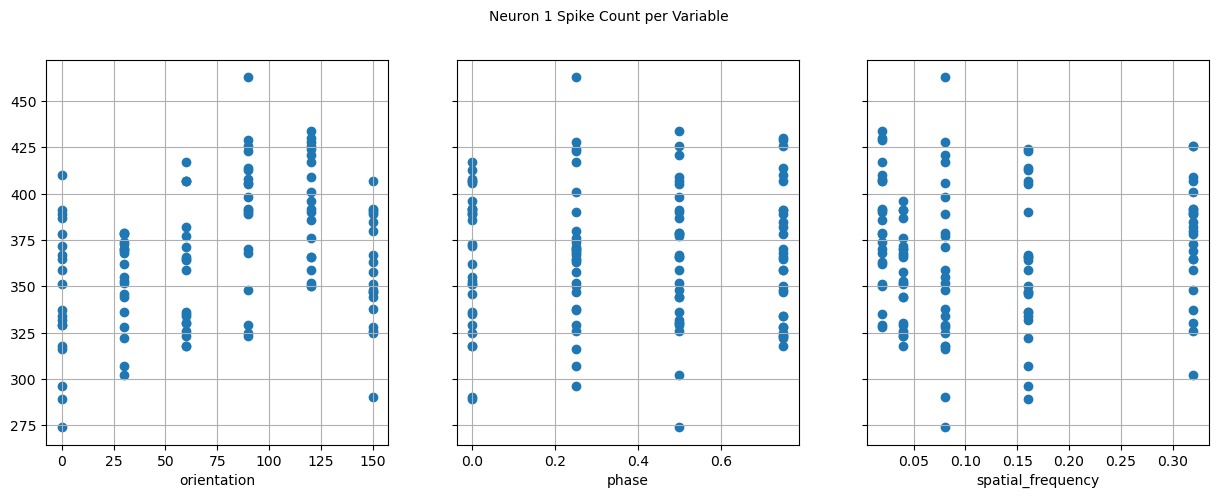

Neuron 2, Number of Samples: 120


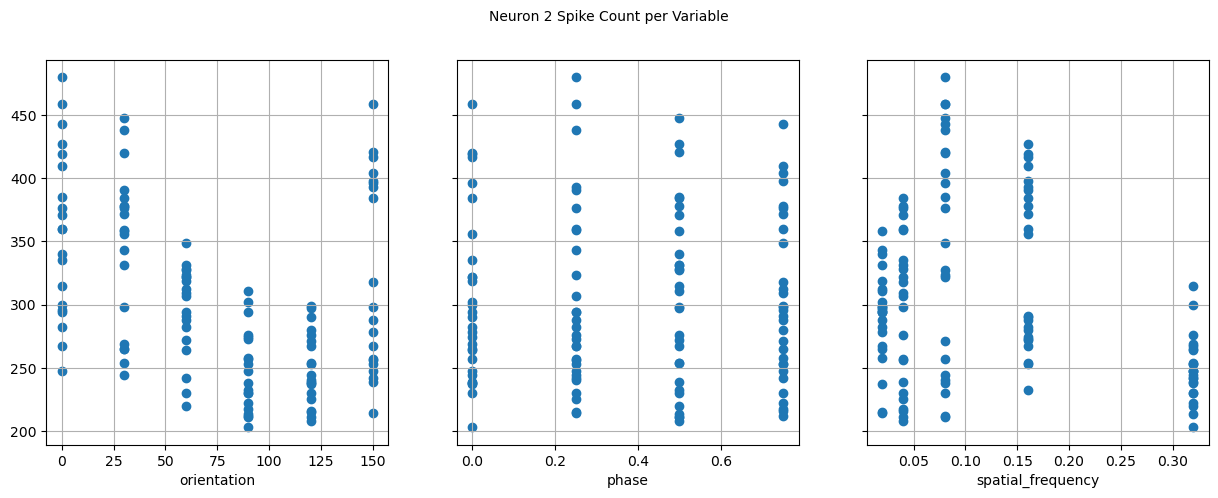

Neuron 3, Number of Samples: 120


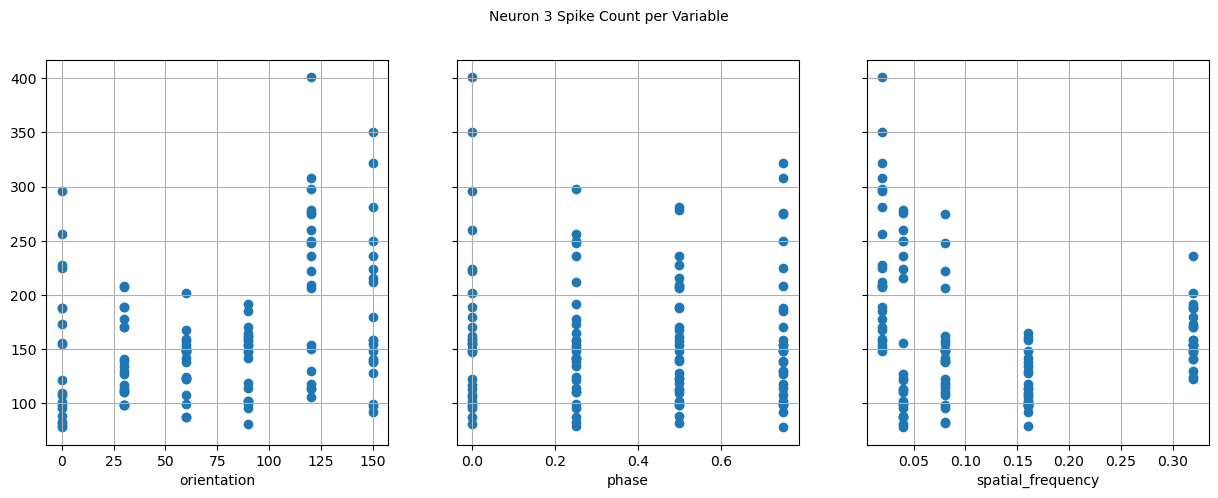

Neuron 4, Number of Samples: 120


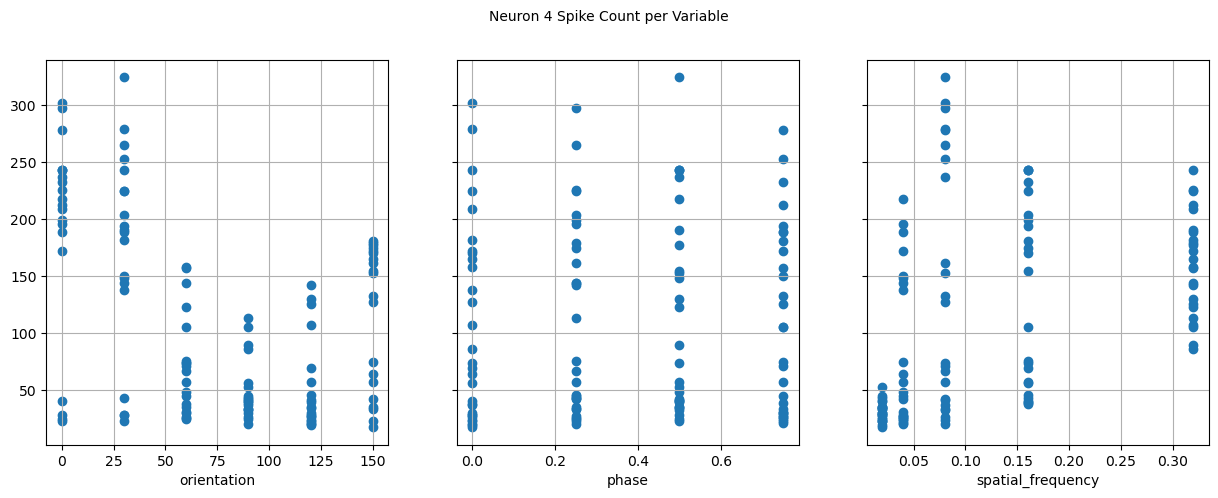

Neuron 5, Number of Samples: 120


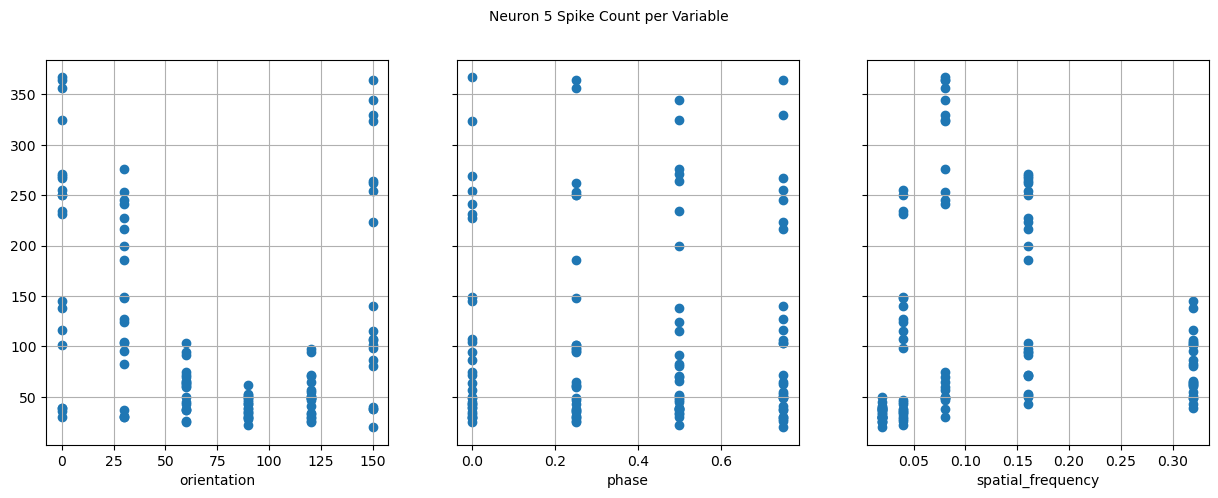

In [9]:
plot_data(dfs)

# Setup

MLP setup. Hidden layers with size 64-128-256-512-1024-\256-64, RMSE loss, AdamW with weight decay value 0.025 and LeakyReLU activation.

In [10]:
class MLP(nn.Module):

    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
        )

    def forward(self, X):
        return self.layers(X)

class RMSELoss(nn.Module):

    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps) # add epsilon to avoid problems with derivative at 0
        return loss

criterion = RMSELoss()

def create_mlp(input_size):
    """Create the instance of the MLP and optimizer

    Args:
        input_size (int): size of the input layer (depends on the data)

    Returns:
        tuple: MLP model and corresponding Adam optimizer
    """

    model = MLP(input_size)
    opt = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=0.025)

    return model, opt

def train(model, opt, train_dataloader, test_dataloader, epochs = 50):
    """
    Train the model
    """

    train_loss_epoch = []
    test_loss_epoch = []

    for epoch in range(epochs):

        model.train()
        epoch_train_loss = 0

        for x, y in train_dataloader:
            opt.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            opt.step()

            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_dataloader)
        train_loss_epoch.append(epoch_train_loss)

        model.eval()
        epoch_test_loss = 0
        with torch.no_grad():
            for x, y in test_dataloader:
                y_pred = model(x)
                loss = criterion(y_pred, y)
                epoch_test_loss += loss.item()
        epoch_test_loss /= len(test_dataloader)
        test_loss_epoch.append(epoch_test_loss)

        print(f"Epoch {epoch + 1}\tTrain loss: {epoch_train_loss}\tTest loss: {epoch_test_loss}")

    plt.plot(train_loss_epoch, label = "train")
    plt.plot(test_loss_epoch, label = "test")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid()
    plt.show()
    
def get_prediction_mlp(df, model, orientation, spatial_frequency, phase, order=1, size=0.3, sinusoidal=False, combined = False):
    """
    Function to get the prediction for the mlp in the right formats.

    Args:
        df (pandas.core.frame.DataFrame): Dataframe containing the features and the output variable, that are used for the scaling
        model (OLS object): model that we will use for the regression
        orientation(float): orientation of the grating
        spatial_frequency(float): spatial frequency of the grating
        phase(float): phase of the grating
        variables_to_keep(list): variables of the regression that we want to keep
        order (int, optional): Order of polynomial features. Defaults to 1.
        size (float, optional): Test size. Defaults to 0.3.
        sinusoidal (bool, optional): Whether to include sinusoidal features. Defaults to False.
        combined (bool, optional): Whether to include both polynomial and sinusoidal features. No need to specificy sinusoidal. Detaults to False.

    Returns:
        float: predicted value
    """

    #useful for scaling
    X1 = np.array(df[["orientation", "phase", "spatial_frequency"]])

    if sinusoidal:
        X_sin1 = np.apply_along_axis(lambda x: np.sin(x), 0, X1)
        X_cos1 = np.apply_along_axis(lambda x: np.cos(x), 0, X1)
        X_feat1 = np.hstack((X_sin1, X_cos1))
    elif combined:
        X_sin1 = np.apply_along_axis(lambda x: np.sin(x), 0, X1)
        X_cos1 = np.apply_along_axis(lambda x: np.cos(x), 0, X1)
        poly_features = preprocessing.PolynomialFeatures(order, include_bias=False)
        X_poly1 = poly_features.fit_transform(X1)
        X_feat1 = np.hstack((X_poly1, X_sin1, X_cos1))
    else:
        poly_features = preprocessing.PolynomialFeatures(order, include_bias=False)
        X_feat1 = poly_features.fit_transform(X1)

    scaler = preprocessing.StandardScaler()
    X_feat_norm = scaler.fit_transform(X_feat1)

    #actual prediction
    X = np.array([[orientation, phase, spatial_frequency]])
    bias = np.ones((X.shape[0], 1))

    if sinusoidal:
        X_sin = np.apply_along_axis(lambda x: np.sin(x), 0, X)
        X_cos = np.apply_along_axis(lambda x: np.cos(x), 0, X)
        X_feat = np.hstack((X_sin, X_cos))
    elif combined:
        X_sin = np.apply_along_axis(lambda x: np.sin(x), 0, X)
        X_cos = np.apply_along_axis(lambda x: np.cos(x), 0, X)
        X_poly = poly_features.transform(X)
        X_feat = np.hstack((X_poly, X_sin, X_cos))
    else:
        X_feat = poly_features.transform(X)

    X_feat_norm = scaler.transform(X_feat)
    X_final = np.hstack((bias, X_feat_norm))

    prediction = model(torch.tensor(X_final, dtype = torch.float32)).item()

    return prediction

def run_mlp(df, epochs = 50):
    """
    Run an MLP with one function.

    Args:
        df (pandas.core.frame.DataFrame): Dataframe containing the features and the output variable
    """
    
    X_train_neuron, X_test_neuron, y_train_neuron, y_test_neuron = get_data(df)
    train_dataset, train_dataloader, test_dataset, test_dataloader = get_data_for_MLP(X_train_neuron, X_test_neuron, y_train_neuron, y_test_neuron)
    mlp_linear, opt = create_mlp(X_train_neuron.shape[1])
    train(mlp_linear, opt, train_dataloader, test_dataloader, epochs)
    
    return mlp_linear

def plot_regression_mlp_2D(df, model, var_to_plot1, var_to_plot2, order = 1, size = 0.3, sinusoidal = False, combined = False, orientation = 0, spatial_frequency = 0, phase = 0):
    # %matplotlib widget

    resolution = 50
    x = np.linspace(min(df[var_to_plot1]) - 0.1, max(df[var_to_plot1]) + 0.1, resolution)
    y = np.linspace(min(df[var_to_plot2]) - 0.1, max(df[var_to_plot2]) + 0.1, resolution)

    z = np.ones((1,len(x)))

    #get the predictions
    if var_to_plot1 == 'spatial_frequency':
        if var_to_plot2 == 'phase':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, orientation, j, i, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))
        if var_to_plot2 == 'orientation':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, i, j, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))
    if var_to_plot1 == 'phase':
        if var_to_plot2 == 'spatial_frequency':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, orientation, i, j, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))
        if var_to_plot2 == 'orientation':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, i, spatial_frequency, j, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))
    if var_to_plot1 == 'orientation':
        if var_to_plot2 == 'phase':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, j, spatial_frequency, i, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))
        if var_to_plot2 == 'spatial_frequency':
            for i in y:
                temp = []
                for j in x:
                    temp.append(get_prediction_mlp(df, model, j, i, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
                z = np.vstack((z, temp))

    z = z[1:,:]

    x, y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z)

    ax.scatter(df[var_to_plot1], df[var_to_plot2], df['spike_count'])

    ax.set_xlabel(var_to_plot1)
    ax.set_ylabel(var_to_plot2)
    ax.set_zlabel('spike count')
    ax.set_title('3D Surface Plot')

    plt.show()
    
def plot_regression_mlp_1D(df, model, var_to_plot, order = 1, size = 0.3, sinusoidal = False, combined = False, orientation = 0, spatial_frequency = 0, phase = 0):
    plt.clf()
    %matplotlib inline

    fig, ax = plt.subplots(figsize=(7, 5))

    x = np.linspace(min(df[var_to_plot]) - 0.1, max(df[var_to_plot]) + 0.1, 50)

    y = []
    if var_to_plot == 'spatial_frequency':
        for i in x:
            y.append(get_prediction_mlp(df, model, orientation, i, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
    if var_to_plot == 'orientation':
        for i in x:
            y.append(get_prediction_mlp(df, model, i, spatial_frequency, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
    if var_to_plot == 'phase':
        for i in x:
            y.append(get_prediction_mlp(df, model, orientation, spatial_frequency, i, order = order, size = size, sinusoidal=sinusoidal, combined = combined))


    ax.plot(x, y, "r--.", linewidth=2, label="MLP")

    #scatter points
    x = df[var_to_plot]
    y = df['spike_count']
    ax.plot(x, y, "o", label="data")

    ax.set_xlabel(var_to_plot, fontsize=12)
    ax.set_ylabel("Spike Count", fontsize=12)
    ax.set_title("Fitted Model by MLP", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(loc="best", fontsize=8)
    ax.grid(True)

    plt.show()

def plot_regression_mlp_1D_all(df, model, order = 1, size = 0.3, sinusoidal = False, combined = False, orientation = 0, spatial_frequency = 0, phase = 0):
    plt.clf()
    %matplotlib inline

    fig, ax = plt.subplots(1,3,figsize=(21, 5))
    count = 0
    for var_to_plot in ['orientation', 'spatial_frequency', 'phase']:
        x = np.linspace(min(df[var_to_plot]) - 0.1, max(df[var_to_plot]) + 0.1, 50)

        y = []
        if var_to_plot == 'spatial_frequency':
            for i in x:
                y.append(get_prediction_mlp(df, model, orientation, i, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
        if var_to_plot == 'orientation':
            for i in x:
                y.append(get_prediction_mlp(df, model, i, spatial_frequency, phase, order = order, size = size, sinusoidal=sinusoidal, combined = combined))
        if var_to_plot == 'phase':
            for i in x:
                y.append(get_prediction_mlp(df, model, orientation, spatial_frequency, i, order = order, size = size, sinusoidal=sinusoidal, combined = combined))


        ax[count].plot(x, y, "r--.", linewidth=2, label="MLP")

        #scatter points
        x = df[var_to_plot]
        y = df['spike_count']
        ax[count].plot(x, y, "o", label="data")

        ax[count].set_xlabel(var_to_plot, fontsize=12)
        ax[count].set_ylabel("Spike Count", fontsize=12)
        ax[count].set_title("Fitted Model by MLP", fontsize=14)
        ax[count].tick_params(axis='both', which='major', labelsize=12)
        ax[count].legend(loc="best", fontsize=8)
        ax[count].grid(True)

        count = count + 1

    plt.show()

# Neuron 1

In [11]:
df_neuron1 = dfs[0]
df_neuron1

unit_id  spike_count  orientation  phase  spatial_frequency
1    951093080          390        150.0   0.50               0.02
7    951093080          332          0.0   0.50               0.16
13   951093080          370         30.0   0.25               0.04
19   951093080          323         60.0   0.75               0.04
25   951093080          318         60.0   0.00               0.08
..         ...          ...          ...    ...                ...
697  951093080          380        150.0   0.25               0.32
703  951093080          329         90.0   0.50               0.04
709  951093080          289          0.0   0.00               0.16
715  951093080          302         30.0   0.50               0.32
721  951093080          370         90.0   0.25               0.02

[120 rows x 5 columns]

## MLP

c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Epoch 1	Train loss: 367.6874694824219	Test loss: 368.35052490234375
Epoch 2	Train loss: 366.85853576660156	Test loss: 368.2674255371094
Epoch 3	Train loss: 366.9501953125	Test loss: 368.1269226074219
Epoch 4	Train loss: 367.9995574951172	Test loss: 367.8097839355469
Epoch 5	Train loss: 369.82342529296875	Test loss: 366.9932861328125
Epoch 6	Train loss: 367.6133728027344	Test loss: 364.7867736816406
Epoch 7	Train loss: 362.91766357421875	Test loss: 358.9073181152344
Epoch 8	Train loss: 355.7661895751953	Test loss: 343.9949035644531
Epoch 9	Train loss: 339.56614685058594	Test loss: 307.8511962890625
Epoch 10	Train loss: 290.9170227050781	Test loss: 225.6868133544922
Epoch 11	Train loss: 187.94013214111328	Test loss: 78.419677734375
Epoch 12	Train loss: 129.85973739624023	Test loss: 164.72096252441406
Epoch 13	Train loss: 136.32606506347656	Test loss: 66.89324188232422
Epoch 14	Train loss: 68.91606521606445	Test loss: 96.84495544433594
Epoch 15	Train loss: 102.43818664550781	Test loss: 10

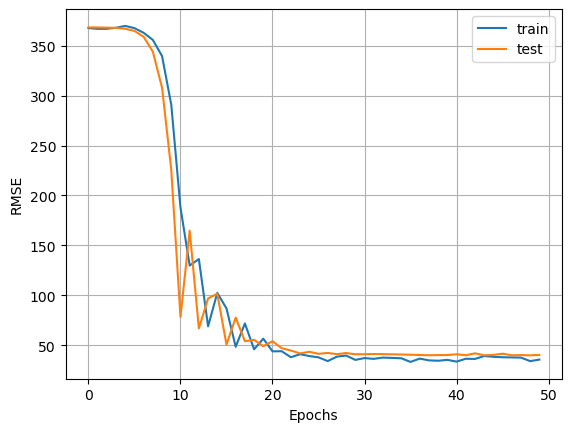

In [12]:
mlp_linear = run_mlp(df_neuron1)

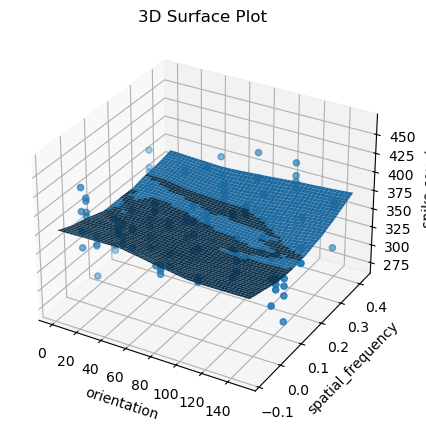

In [13]:
plot_regression_mlp_2D(df_neuron1, mlp_linear, 'orientation', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

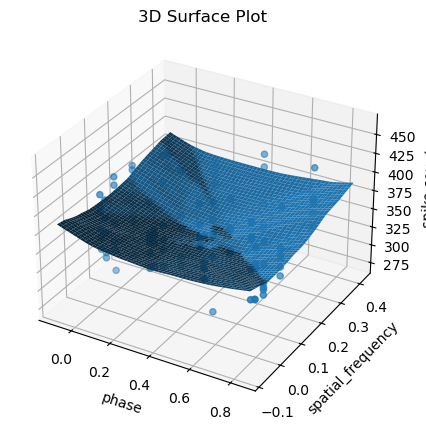

In [14]:
plot_regression_mlp_2D(df_neuron1, mlp_linear, 'phase', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

<Figure size 640x480 with 0 Axes>

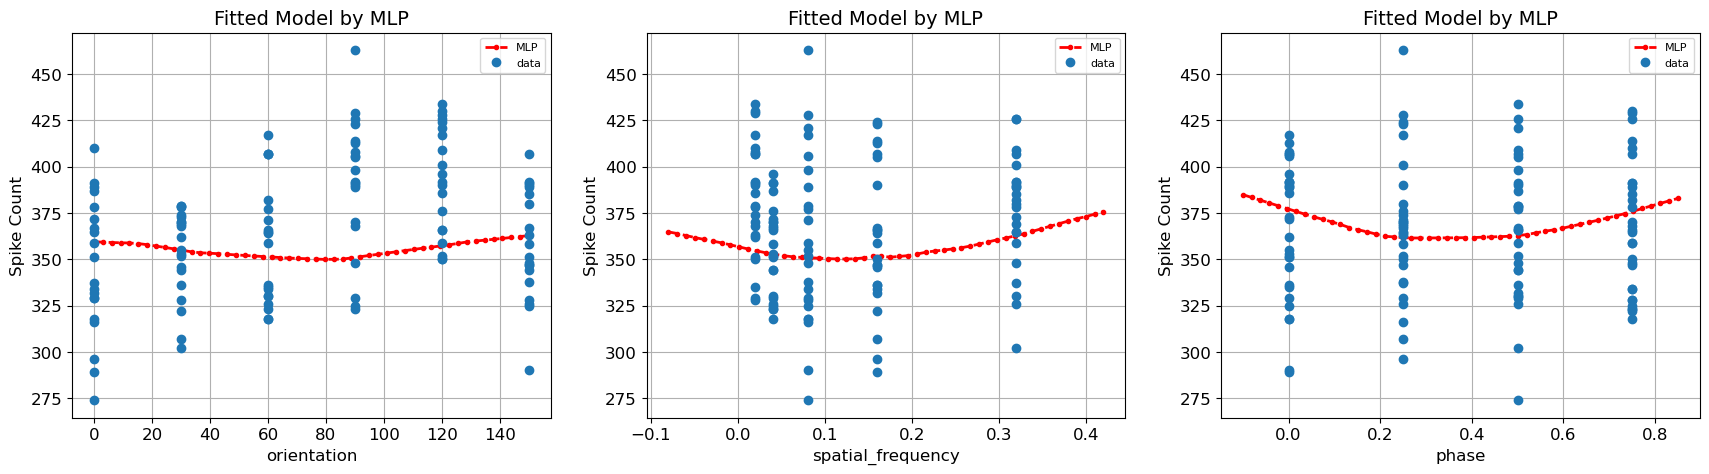

In [15]:
plot_regression_mlp_1D_all(df_neuron1, mlp_linear, orientation = 150, phase = 0.5, spatial_frequency= 0.32)

## Linear Regression

### First-Order Features

In [16]:
X_train_neuron1, X_test_neuron1, y_train_neuron1, y_test_neuron1 = get_data(df_neuron1)
res_order1 = OLS(y_train_neuron1, X_train_neuron1).fit()
print(res_order1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     2.681
Date:                Wed, 01 May 2024   Prob (F-statistic):             0.0524
Time:                        20:50:44   Log-Likelihood:                -413.75
No. Observations:                  84   AIC:                             835.5
Df Residuals:                      80   BIC:                             845.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        367.7554      3.740     98.337      0.0

In [17]:
# step-down
final_features = backward_elimination(y_train_neuron1, X_train_neuron1)
print(f"Final model with significant features: {final_features}")
res_order1_improved = OLS(y_train_neuron1, X_train_neuron1[:, final_features]).fit()
print(res_order1_improved.summary())

Final model with significant features: [0, 1]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7.634
Date:                Wed, 01 May 2024   Prob (F-statistic):            0.00707
Time:                        20:50:44   Log-Likelihood:                -414.03
No. Observations:                  84   AIC:                             832.1
Df Residuals:                      82   BIC:                             836.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

R Squared: 0.085, Adjusted R Squared 0.074
Train RMSE: 35.181
Test RMSE: 37.292


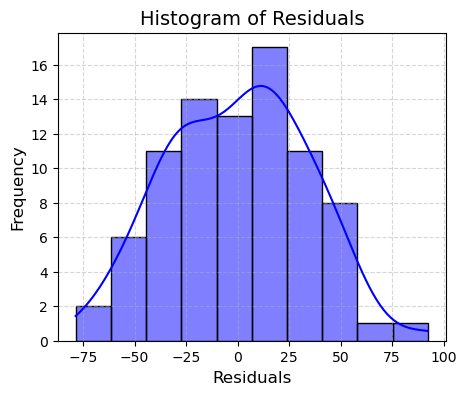

Final equation --> y = 367.61 + 10.27 * orient


In [18]:
summary(res_order1_improved, final_features, X_test_neuron1, y_test_neuron1)

<Figure size 640x480 with 0 Axes>

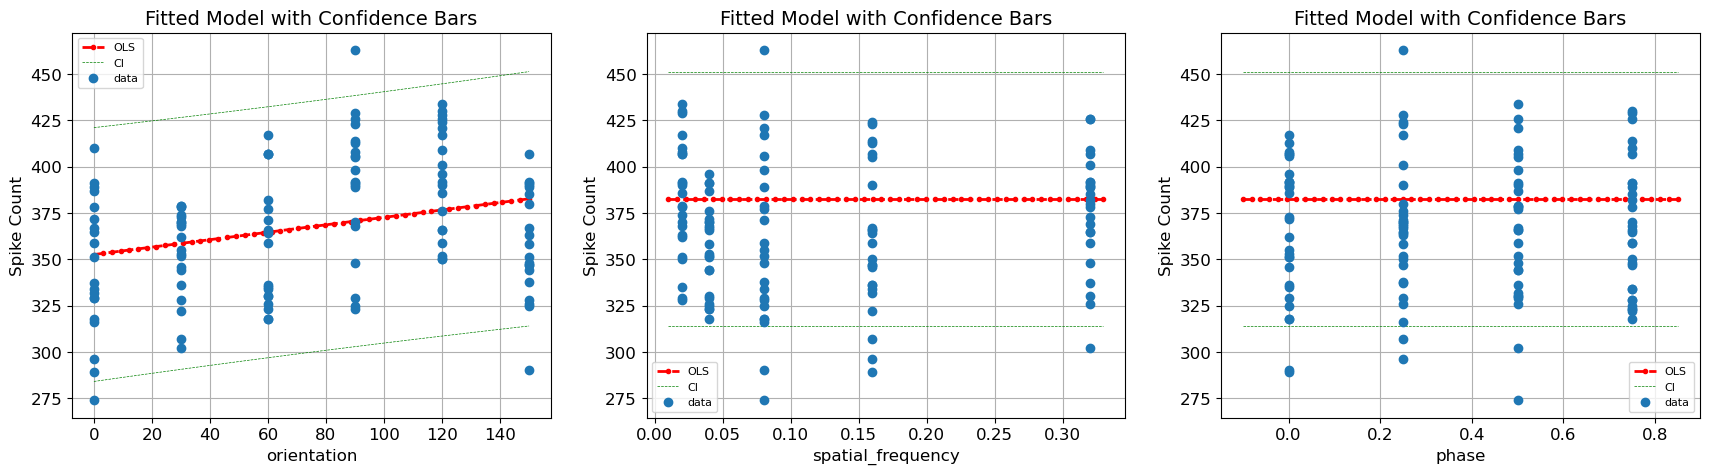

In [19]:
plot_regression_1D_all(df_neuron1, res_order1_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5)

### Quadratic Features

In [20]:
X_train_neuron1, X_test_neuron1, y_train_neuron1, y_test_neuron1 = get_data(df_neuron1, order=2)
res_order2 = OLS(y_train_neuron1, X_train_neuron1).fit()
print(res_order2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     2.917
Date:                Wed, 01 May 2024   Prob (F-statistic):            0.00518
Time:                        20:50:46   Log-Likelihood:                -405.02
No. Observations:                  84   AIC:                             830.0
Df Residuals:                      74   BIC:                             854.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        367.1794      3.523    104.230      0.0

In [21]:
# step-down
final_features = backward_elimination(y_train_neuron1, X_train_neuron1)
print(f"Final model with significant features: {final_features}")
res_order2_improved = OLS(y_train_neuron1, X_train_neuron1[:, final_features]).fit()
print(res_order2_improved.summary())

Final model with significant features: [0, 1, 4, 5]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     7.024
Date:                Wed, 01 May 2024   Prob (F-statistic):           0.000298
Time:                        20:50:46   Log-Likelihood:                -407.95
No. Observations:                  84   AIC:                             823.9
Df Residuals:                      80   BIC:                             833.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


R Squared: 0.208, Adjusted R Squared 0.179
Train RMSE: 35.181
Test RMSE: 38.679


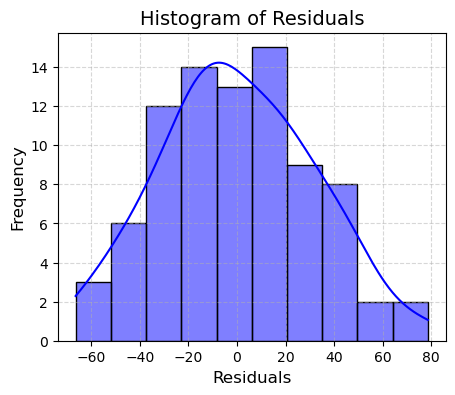

Final equation --> y = 367.52 + 49.84 * orient + -36.99 * orient^2 + -8.78 * (orient * phase)


In [22]:
summary(res_order2_improved, final_features, X_test_neuron1, y_test_neuron1)

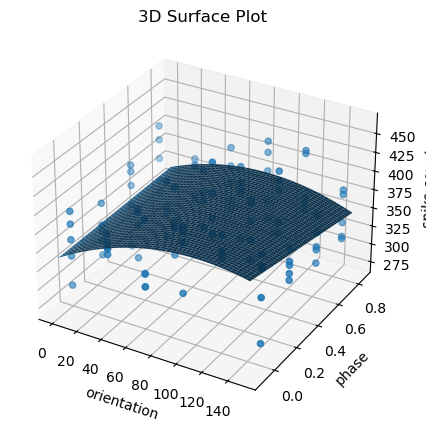

In [23]:
plot_regression_2D(df_neuron1, res_order2_improved, 'orientation', 'phase', final_features, order = 2, spatial_frequency=0.32)

<Figure size 640x480 with 0 Axes>

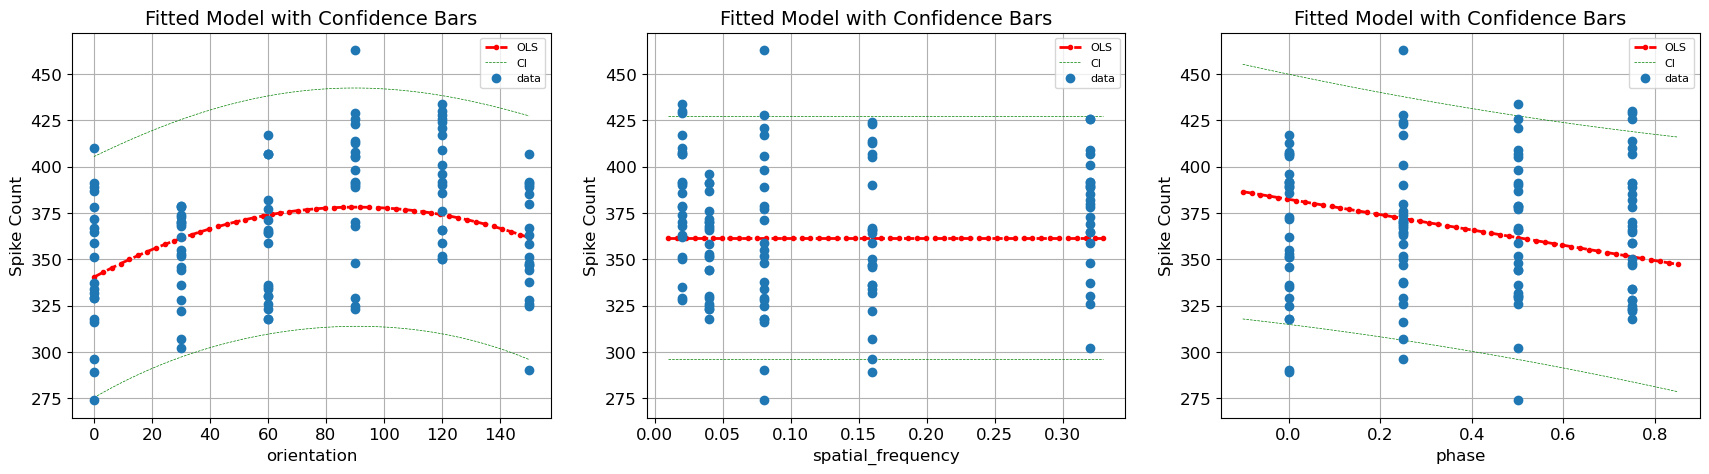

In [24]:
plot_regression_1D_all(df_neuron1, res_order2_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Sinusoidal Features

In [25]:
X_train_neuron1, X_test_neuron1, y_train_neuron1, y_test_neuron1 = get_data(df_neuron1, sinusoidal=True)
res_sinusoidal = OLS(y_train_neuron1, X_train_neuron1).fit()
print(res_sinusoidal.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     4.566
Date:                Wed, 01 May 2024   Prob (F-statistic):           0.000517
Time:                        20:50:53   Log-Likelihood:                -404.99
No. Observations:                  84   AIC:                             824.0
Df Residuals:                      77   BIC:                             841.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        366.0244      3.448    106.166      0.0

In [26]:
# step-down
final_features = backward_elimination(y_train_neuron1, X_train_neuron1)
print(f"Final model with significant features: {final_features}")
res_sinusoidal_improved = OLS(y_train_neuron1, X_train_neuron1[:, final_features]).fit()
print(res_sinusoidal_improved.summary())

Final model with significant features: [0, 1]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     26.98
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.47e-06
Time:                        20:50:53   Log-Likelihood:                -405.82
No. Observations:                  84   AIC:                             815.6
Df Residuals:                      82   BIC:                             820.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

R Squared: 0.248, Adjusted R Squared 0.238
Train RMSE: 35.181
Test RMSE: 39.010


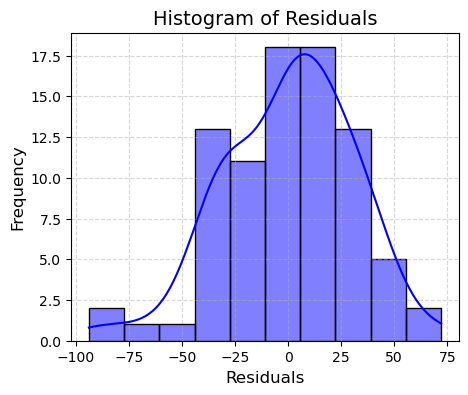

Final equation --> y = 365.70 + 17.09 * sin(orient)


In [27]:
summary(res_sinusoidal_improved, final_features, X_test_neuron1, y_test_neuron1, sinusoidal = True)

<Figure size 640x480 with 0 Axes>

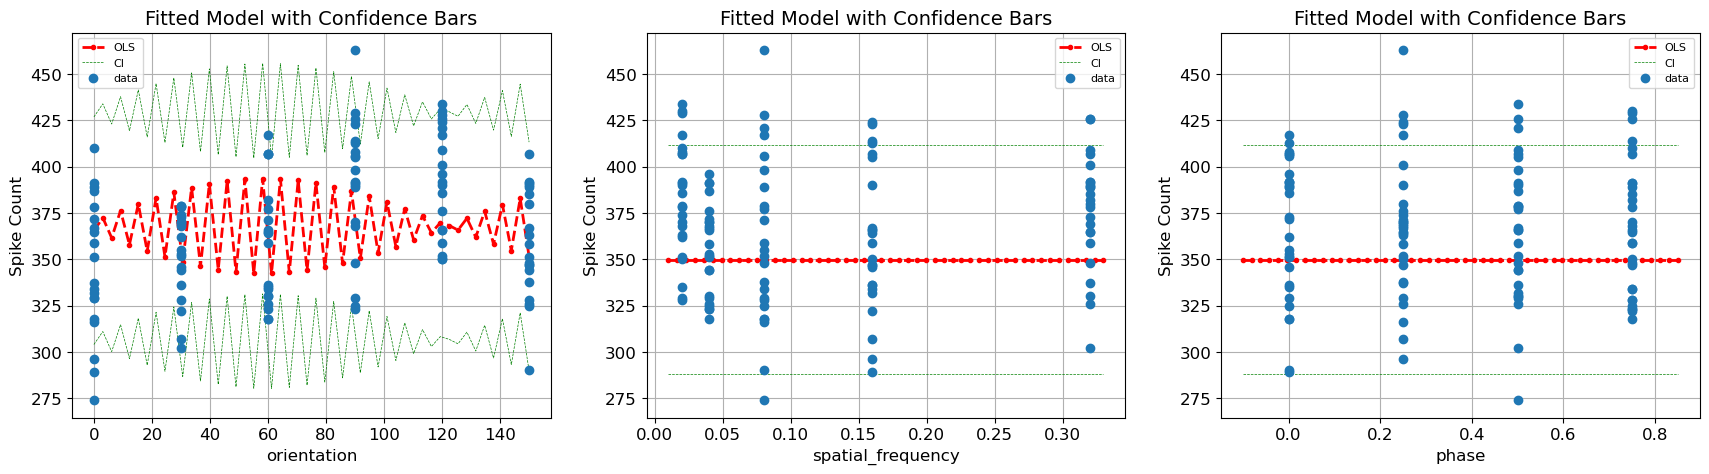

In [28]:
plot_regression_1D_all(df_neuron1, res_sinusoidal_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, sinusoidal=True)

### Combined Features

In [29]:
X_train_neuron1, X_test_neuron1, y_train_neuron1, y_test_neuron1 = get_data(df_neuron1, order=2, combined=True)
res_combined = OLS(y_train_neuron1, X_train_neuron1).fit()
print(res_combined.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     3.305
Date:                Wed, 01 May 2024   Prob (F-statistic):           0.000467
Time:                        20:50:55   Log-Likelihood:                -396.22
No. Observations:                  84   AIC:                             822.4
Df Residuals:                      69   BIC:                             858.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        366.3010      3.303    110.895      0.0

In [30]:
final_features = backward_elimination(y_train_neuron1, X_train_neuron1)
print(f"Final model with significant features: {final_features}")
res_combined_improved = OLS(y_train_neuron1, X_train_neuron1[:, final_features]).fit()
print(res_combined_improved.summary())

Final model with significant features: [0, 1, 5, 10]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     12.08
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.33e-06
Time:                        20:50:55   Log-Likelihood:                -402.08
No. Observations:                  84   AIC:                             812.2
Df Residuals:                      80   BIC:                             821.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

R Squared: 0.312, Adjusted R Squared 0.286
Train RMSE: 35.181
Test RMSE: 39.057


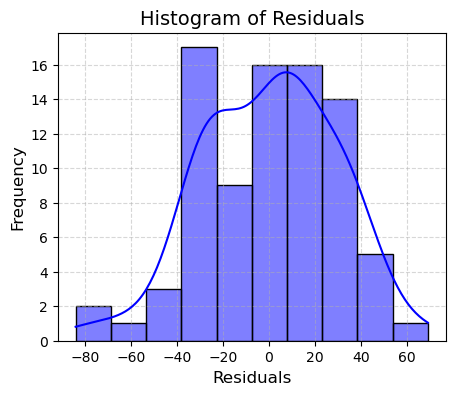

Final equation --> y = 366.34 + 11.59 * orient + -7.63 * (orient * phase) + 15.37 * sin(orient)


In [31]:
summary(res_combined_improved, final_features, X_test_neuron1, y_test_neuron1)

<Figure size 640x480 with 0 Axes>

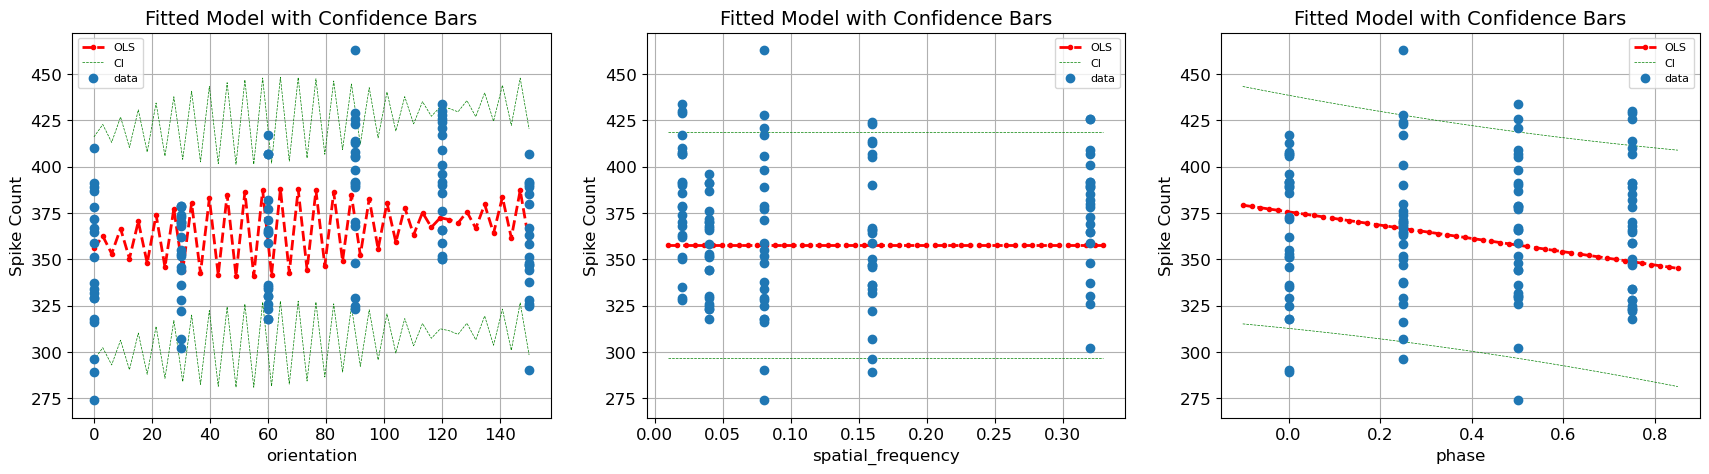

In [32]:
plot_regression_1D_all(df_neuron1, res_combined_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, combined=True, order = 2)

# Neuron 2

In [33]:
df_neuron2 = dfs[1]
df_neuron2

unit_id  spike_count  orientation  phase  spatial_frequency
2    951093283          267        150.0   0.50               0.02
8    951093283          427          0.0   0.50               0.16
14   951093283          359         30.0   0.25               0.04
20   951093283          309         60.0   0.75               0.04
26   951093283          322         60.0   0.00               0.08
..         ...          ...          ...    ...                ...
698  951093283          242        150.0   0.25               0.32
704  951093283          211         90.0   0.50               0.04
710  951093283          419          0.0   0.00               0.16
716  951093283          254         30.0   0.50               0.32
722  951093283          294         90.0   0.25               0.02

[120 rows x 5 columns]

## MLP

c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Epoch 1	Train loss: 311.6583709716797	Test loss: 315.837890625
Epoch 2	Train loss: 310.42840576171875	Test loss: 315.7574462890625
Epoch 3	Train loss: 313.0576477050781	Test loss: 315.6233825683594
Epoch 4	Train loss: 303.09251403808594	Test loss: 315.324462890625
Epoch 5	Train loss: 307.2532958984375	Test loss: 314.56158447265625
Epoch 6	Train loss: 306.27667236328125	Test loss: 312.5065612792969
Epoch 7	Train loss: 299.35142517089844	Test loss: 307.0301818847656
Epoch 8	Train loss: 299.9394989013672	Test loss: 293.1022644042969
Epoch 9	Train loss: 279.5125427246094	Test loss: 259.3325500488281
Epoch 10	Train loss: 238.5702362060547	Test loss: 183.4306640625
Epoch 11	Train loss: 149.13808059692383	Test loss: 86.55321502685547
Epoch 12	Train loss: 127.11352157592773	Test loss: 125.93119812011719
Epoch 13	Train loss: 118.79676818847656	Test loss: 75.51717376708984
Epoch 14	Train loss: 83.556884765625	Test loss: 104.69540405273438
Epoch 15	Train loss: 105.16067504882812	Test loss: 98.122

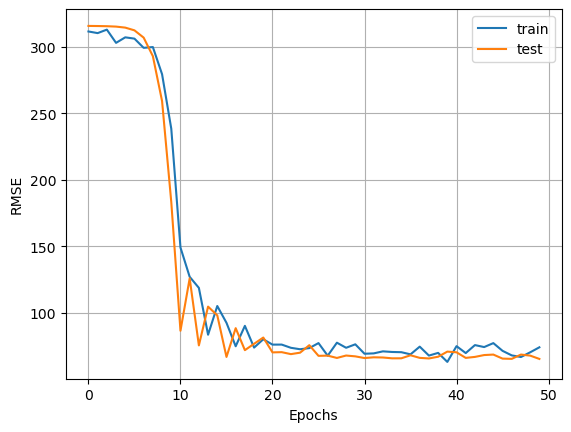

In [34]:
mlp_linear = run_mlp(df_neuron2)

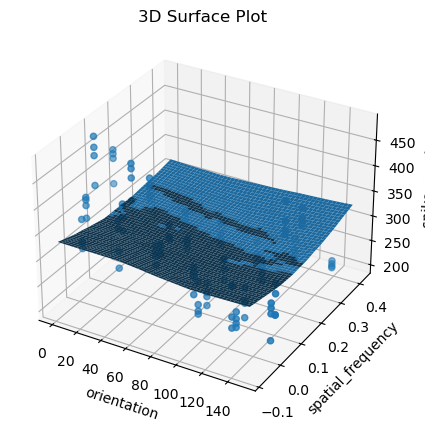

In [35]:
plot_regression_mlp_2D(df_neuron2, mlp_linear, 'orientation', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

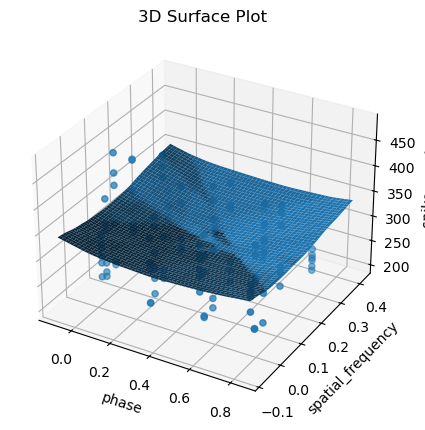

In [36]:
plot_regression_mlp_2D(df_neuron2, mlp_linear, 'phase', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

<Figure size 640x480 with 0 Axes>

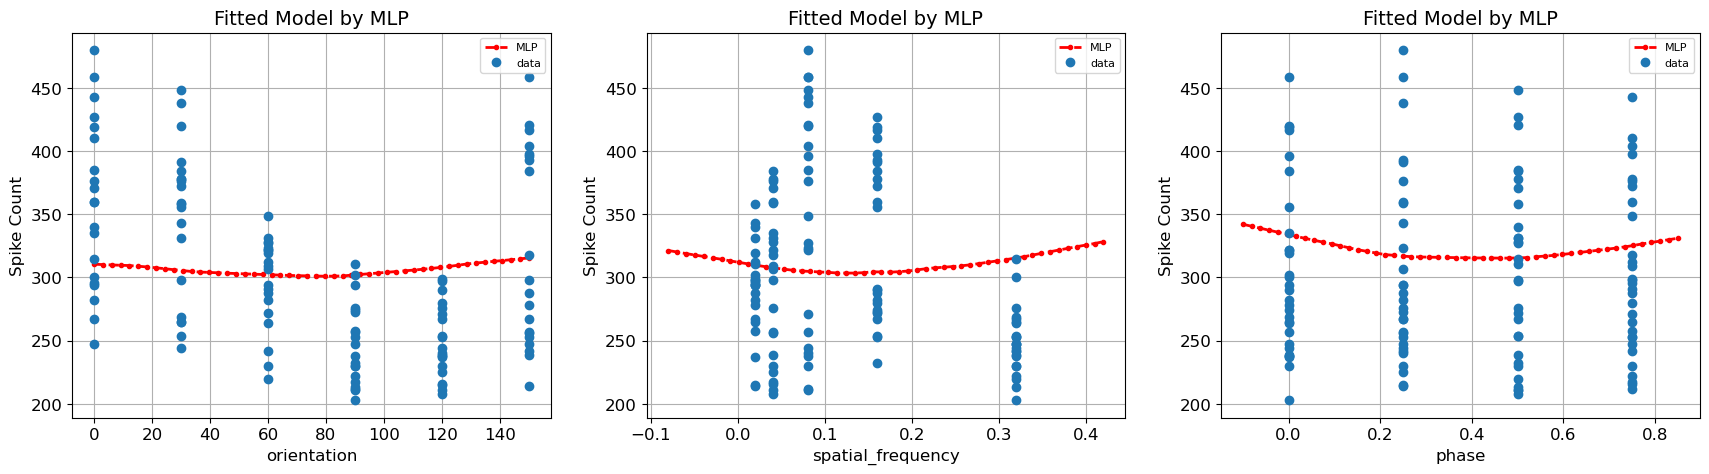

In [37]:
plot_regression_mlp_1D_all(df_neuron2, mlp_linear, orientation = 150, phase = 0.5, spatial_frequency= 0.32)

## Linear Regression

### First-Order Features

In [38]:
X_train_neuron2, X_test_neuron2, y_train_neuron2, y_test_neuron2 = get_data(df_neuron2)
res_order1 = OLS(y_train_neuron2, X_train_neuron2).fit()
print(res_order1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     7.182
Date:                Wed, 01 May 2024   Prob (F-statistic):           0.000249
Time:                        20:51:04   Log-Likelihood:                -465.26
No. Observations:                  84   AIC:                             938.5
Df Residuals:                      80   BIC:                             948.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        299.2824      6.905     43.341      0.0

In [39]:
final_features = backward_elimination(y_train_neuron2, X_train_neuron2)
print(f"Final model with significant features: {final_features}")
res_order1_improved = OLS(y_train_neuron2, X_train_neuron2[:, final_features]).fit()
print(res_order1_improved.summary())

Final model with significant features: [0, 1, 3]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     10.81
Date:                Wed, 01 May 2024   Prob (F-statistic):           6.88e-05
Time:                        20:51:04   Log-Likelihood:                -465.34
No. Observations:                  84   AIC:                             936.7
Df Residuals:                      81   BIC:                             944.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

R Squared: 0.211, Adjusted R Squared 0.191
Train RMSE: 69.763
Test RMSE: 58.628


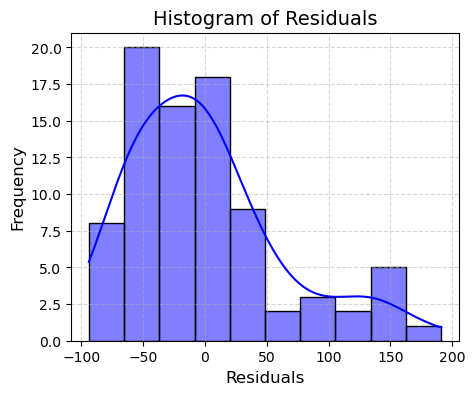

Final equation --> y = 299.42 + -26.29 * orient + -17.20 * freq


In [40]:
summary(res_order1_improved, final_features, X_test_neuron2, y_test_neuron2)

<Figure size 640x480 with 0 Axes>

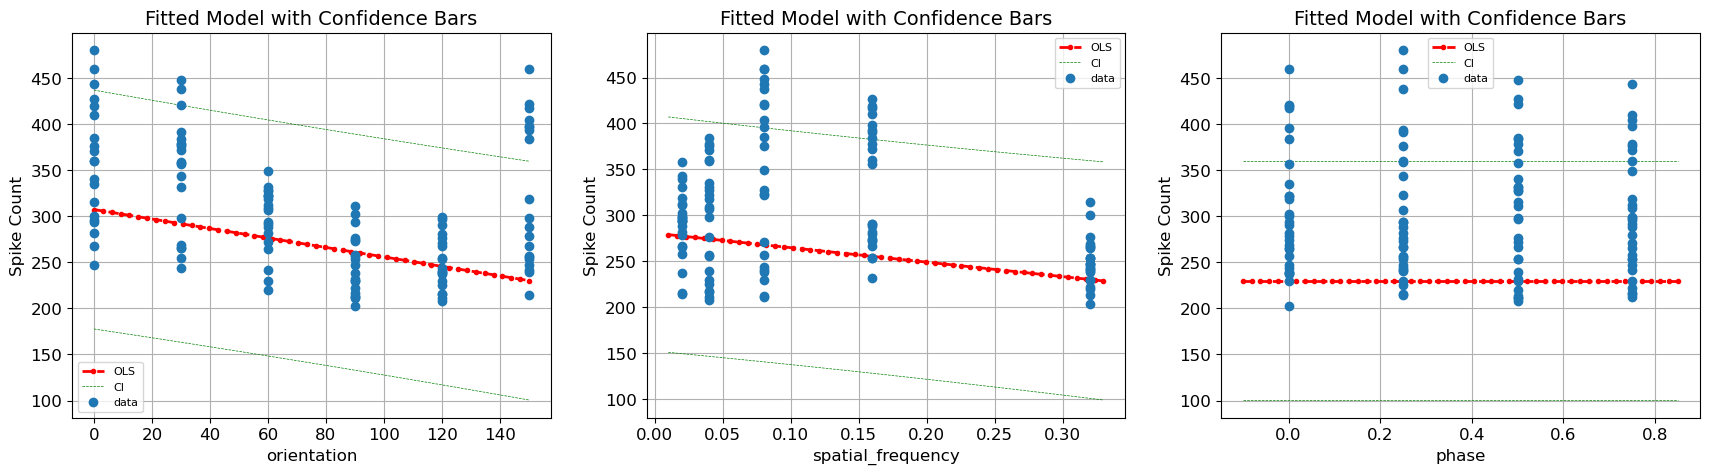

In [41]:
plot_regression_1D_all(df_neuron2, res_order1_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5)

### Quadratic Features

In [42]:
X_train_neuron2, X_test_neuron2, y_train_neuron2, y_test_neuron2 = get_data(df_neuron2, order = 2)
res_order2 = OLS(y_train_neuron2, X_train_neuron2).fit()
print(res_order2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     9.847
Date:                Wed, 01 May 2024   Prob (F-statistic):           9.36e-10
Time:                        20:51:06   Log-Likelihood:                -442.21
No. Observations:                  84   AIC:                             904.4
Df Residuals:                      74   BIC:                             928.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        298.7475      5.485     54.467      0.0

In [43]:
final_features = backward_elimination(y_train_neuron2, X_train_neuron2)
print(f"Final model with significant features: {final_features}")
res_order2_improved = OLS(y_train_neuron2, X_train_neuron2[:, final_features]).fit()
print(res_order2_improved.summary())

Final model with significant features: [0, 1, 3, 4, 9]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     21.75
Date:                Wed, 01 May 2024   Prob (F-statistic):           3.98e-12
Time:                        20:51:06   Log-Likelihood:                -444.09
No. Observations:                  84   AIC:                             898.2
Df Residuals:                      79   BIC:                             910.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.524, Adjusted R Squared 0.500
Train RMSE: 69.763
Test RMSE: 43.763


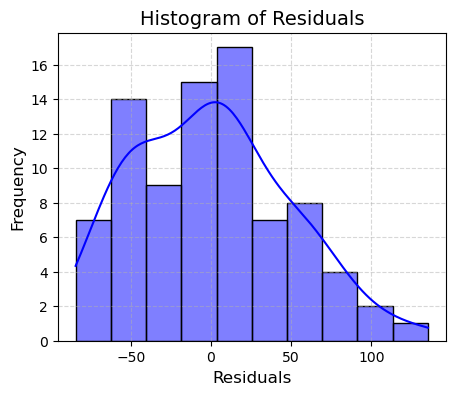

Final equation --> y = 299.16 + -116.02 * orient + 110.77 * freq + 95.25 * orient^2 + -128.87 * freq^2


In [44]:
summary(res_order2_improved, final_features, X_test_neuron2, y_test_neuron2)

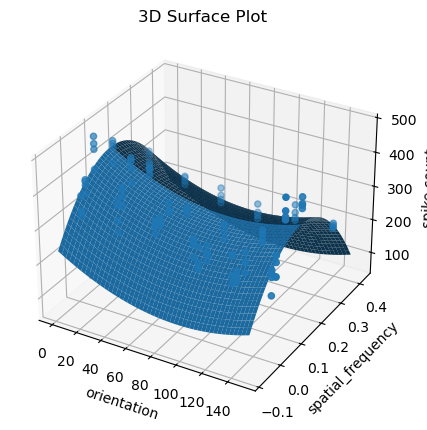

In [45]:
plot_regression_2D(df_neuron2, res_order2_improved, 'orientation', 'spatial_frequency', final_features, order = 2, phase = 0.5)

<Figure size 640x480 with 0 Axes>

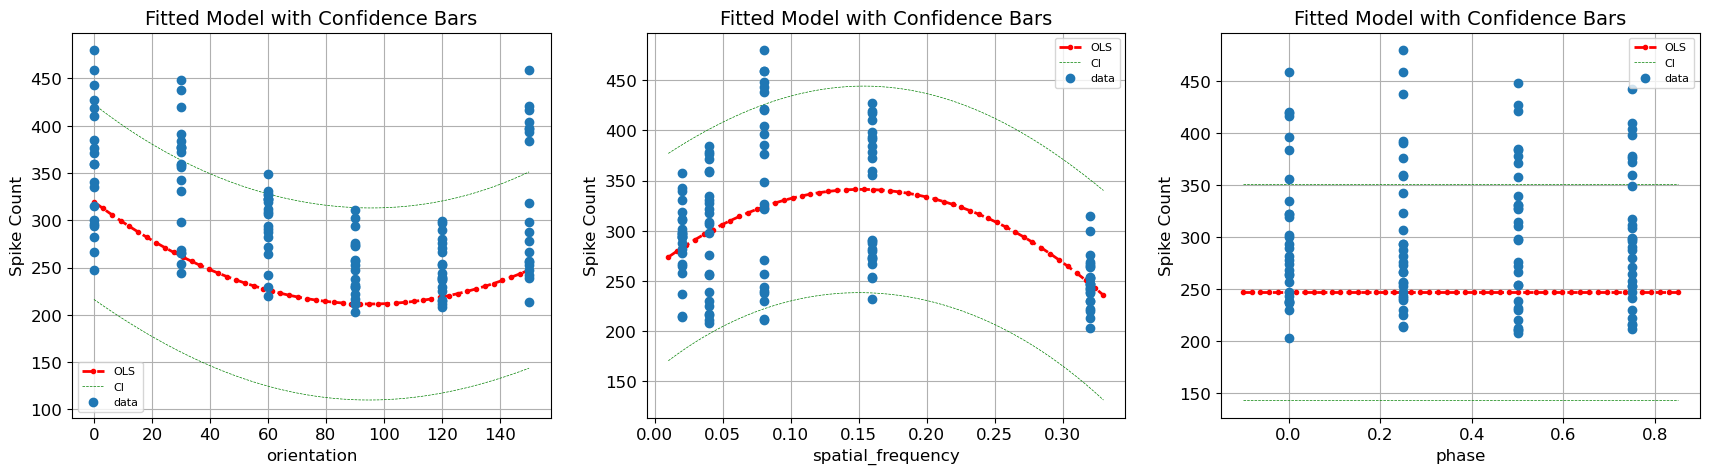

In [46]:
plot_regression_1D_all(df_neuron2, res_order2_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Sinusoidal Features

In [47]:
X_train_neuron2, X_test_neuron2, y_train_neuron2, y_test_neuron2 = get_data(df_neuron2, sinusoidal=True)
res_sinusoidal = OLS(y_train_neuron2, X_train_neuron2).fit()
print(res_sinusoidal.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     12.75
Date:                Wed, 01 May 2024   Prob (F-statistic):           6.12e-10
Time:                        20:51:13   Log-Likelihood:                -446.30
No. Observations:                  84   AIC:                             906.6
Df Residuals:                      77   BIC:                             923.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        302.4351      5.638     53.639      0.0

In [48]:
final_features = backward_elimination(y_train_neuron2, X_train_neuron2)
print(f"Final model with significant features: {final_features}")
res_sinusoidal_improved = OLS(y_train_neuron2, X_train_neuron2[:, final_features]).fit()
print(res_sinusoidal_improved.summary())

Final model with significant features: [0, 1, 3, 4, 6]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     19.34
Date:                Wed, 01 May 2024   Prob (F-statistic):           4.00e-11
Time:                        20:51:13   Log-Likelihood:                -446.60
No. Observations:                  84   AIC:                             903.2
Df Residuals:                      79   BIC:                             915.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.495, Adjusted R Squared 0.469
Train RMSE: 69.763
Test RMSE: 44.787


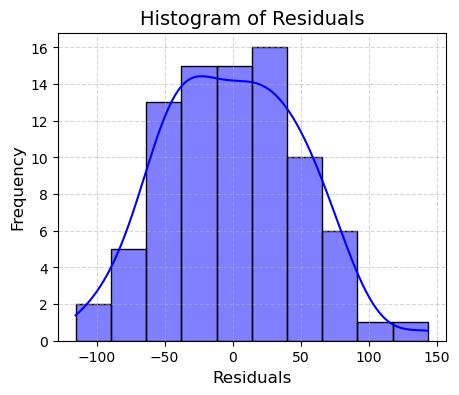

Final equation --> y = 302.79 + -31.81 * sin(orient) + 94.86 * sin(freq) + 13.30 * cos(orient) + 112.88 * cos(freq)


In [49]:
summary(res_sinusoidal_improved, final_features, X_test_neuron2, y_test_neuron2, sinusoidal=True)

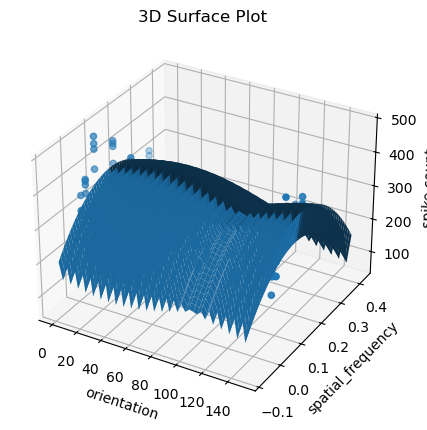

In [50]:
plot_regression_2D(df_neuron2, res_sinusoidal_improved, 'orientation', 'spatial_frequency', final_features, sinusoidal=True, phase = 0.5)

<Figure size 640x480 with 0 Axes>

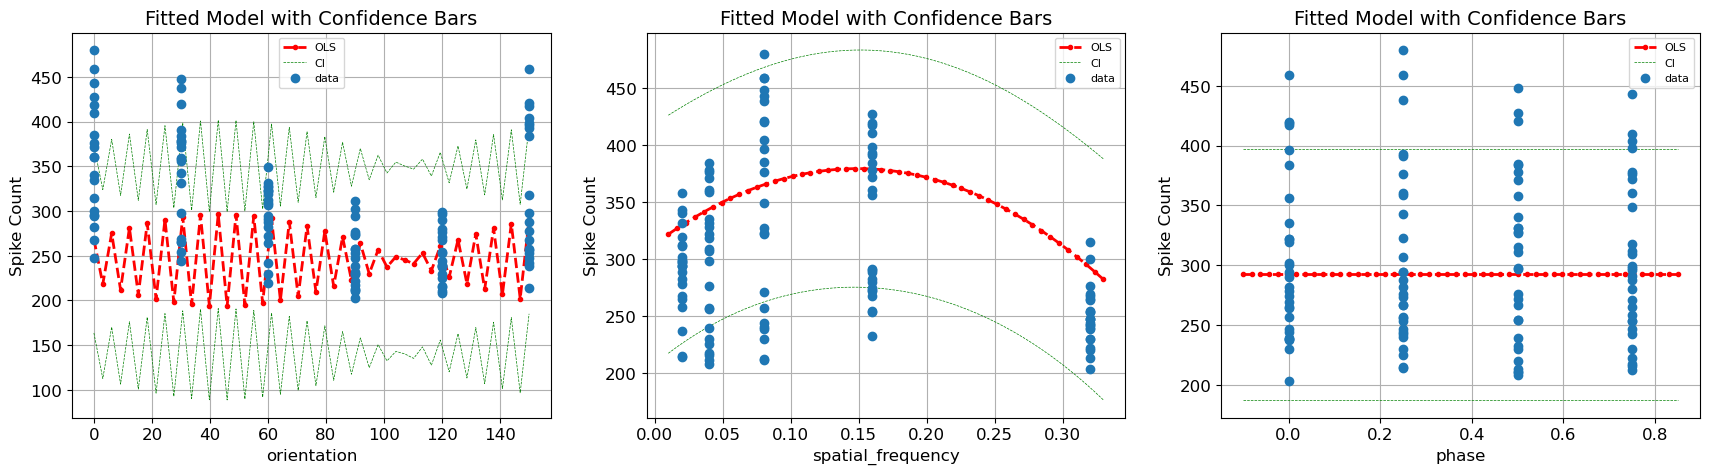

In [51]:
plot_regression_1D_all(df_neuron2, res_sinusoidal_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, sinusoidal=True)

### Combined Features

In [52]:
X_train_neuron2, X_test_neuron2, y_train_neuron2, y_test_neuron2 = get_data(df_neuron2, order=2, combined=True)
res_combined = OLS(y_train_neuron2, X_train_neuron2).fit()
print(res_combined.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     8.933
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.05e-10
Time:                        20:51:20   Log-Likelihood:                -431.84
No. Observations:                  84   AIC:                             893.7
Df Residuals:                      69   BIC:                             930.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        300.4202      5.048     59.512      0.0

In [53]:
final_features = backward_elimination(y_train_neuron2, X_train_neuron2)
print(f"Final model with significant features: {final_features}")
res_combined_improved = OLS(y_train_neuron2, X_train_neuron2[:, final_features]).fit()
print(res_combined_improved.summary())

Final model with significant features: [0, 1, 4, 6, 10, 12, 15]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     21.57
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.06e-14
Time:                        20:51:20   Log-Likelihood:                -433.86
No. Observations:                  84   AIC:                             881.7
Df Residuals:                      77   BIC:                             898.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

R Squared: 0.627, Adjusted R Squared 0.598
Train RMSE: 69.763
Test RMSE: 37.448


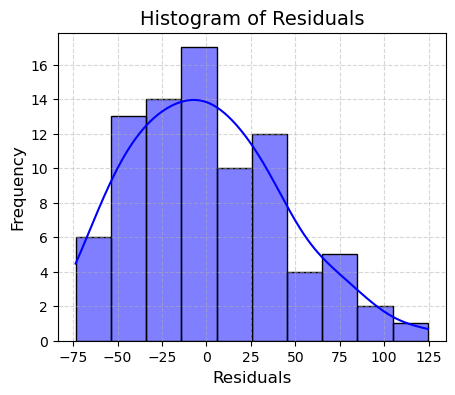

Final equation --> y = 300.64 + -93.80 * orient + 65.41 * orient^2 + 19.56 * (orient * freq) + -22.24 * sin(orient) + 90.73 * sin(freq) + 121.29 * cos(freq)


In [54]:
summary(res_combined_improved, final_features, X_test_neuron2, y_test_neuron2)

<Figure size 640x480 with 0 Axes>

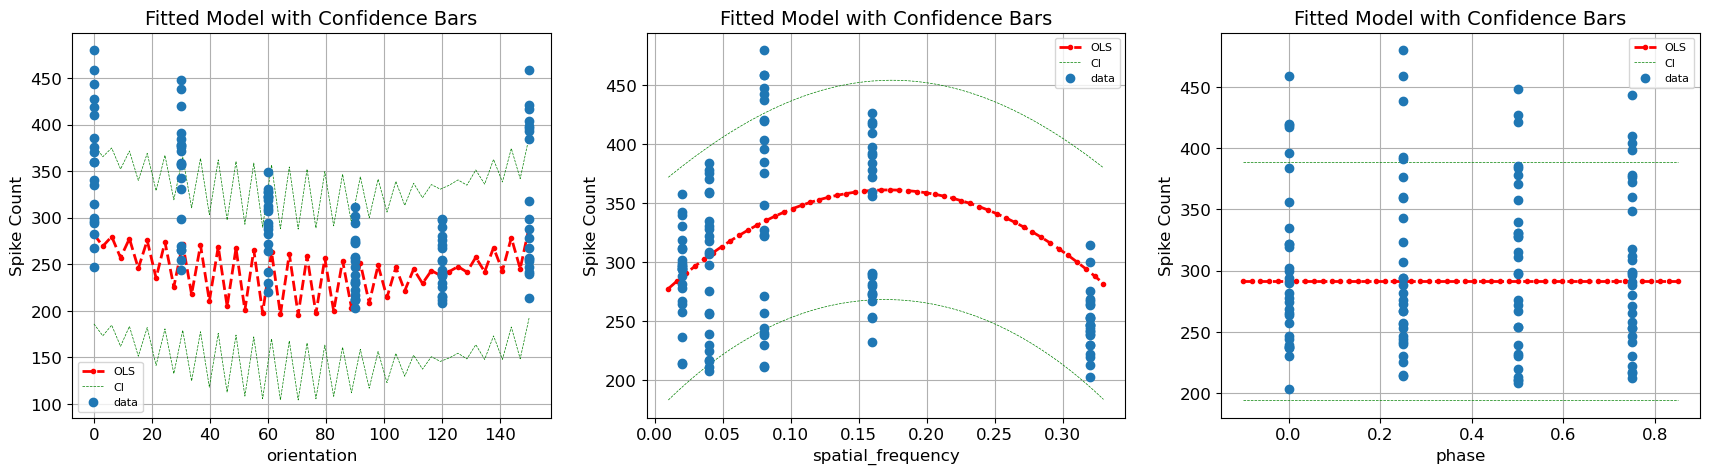

In [55]:
plot_regression_1D_all(df_neuron2, res_combined_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, combined=True, order = 2)

# Neuron 3

In [56]:
df_neuron3 = dfs[2]
df_neuron3

unit_id  spike_count  orientation  phase  spatial_frequency
3    951093608          281        150.0   0.50               0.02
9    951093608          109          0.0   0.50               0.16
15   951093608          110         30.0   0.25               0.04
21   951093608           99         60.0   0.75               0.04
27   951093608          122         60.0   0.00               0.08
..         ...          ...          ...    ...                ...
699  951093608          158        150.0   0.25               0.32
705  951093608          102         90.0   0.50               0.04
711  951093608          101          0.0   0.00               0.16
717  951093608          189         30.0   0.50               0.32
723  951093608          157         90.0   0.25               0.02

[120 rows x 5 columns]

## MLP

c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Epoch 1	Train loss: 167.3141326904297	Test loss: 176.05479431152344
Epoch 2	Train loss: 176.56069946289062	Test loss: 175.9803466796875
Epoch 3	Train loss: 176.761962890625	Test loss: 175.8599395751953
Epoch 4	Train loss: 178.0328369140625	Test loss: 175.59783935546875
Epoch 5	Train loss: 175.61434173583984	Test loss: 174.9416961669922
Epoch 6	Train loss: 171.24452209472656	Test loss: 173.18801879882812
Epoch 7	Train loss: 168.4127960205078	Test loss: 168.51913452148438
Epoch 8	Train loss: 163.32450103759766	Test loss: 156.66127014160156
Epoch 9	Train loss: 146.92650604248047	Test loss: 128.3773651123047
Epoch 10	Train loss: 102.97634506225586	Test loss: 76.07781219482422
Epoch 11	Train loss: 87.96641159057617	Test loss: 84.58077239990234
Epoch 12	Train loss: 86.93534088134766	Test loss: 67.1639633178711
Epoch 13	Train loss: 72.18054962158203	Test loss: 75.32511138916016
Epoch 14	Train loss: 81.58097076416016	Test loss: 75.4676284790039
Epoch 15	Train loss: 62.839284896850586	Test loss

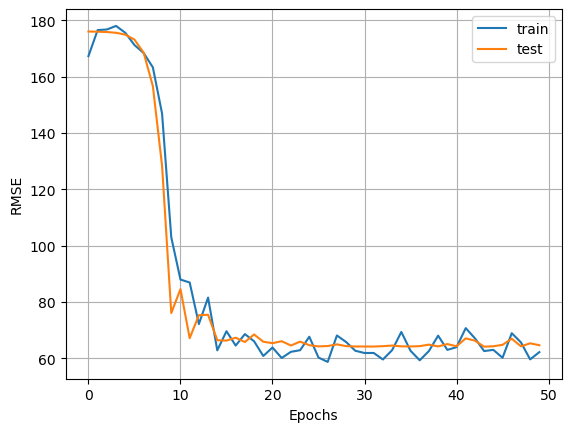

In [57]:
mlp_linear = run_mlp(df_neuron3)

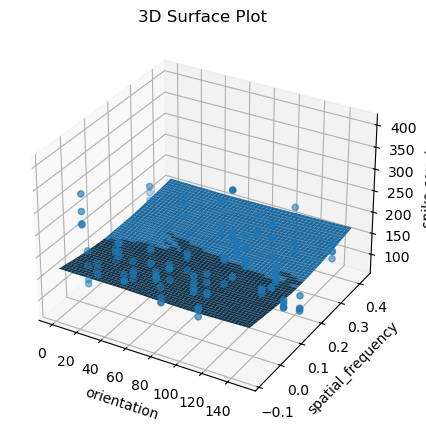

In [58]:
plot_regression_mlp_2D(df_neuron3, mlp_linear, 'orientation', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

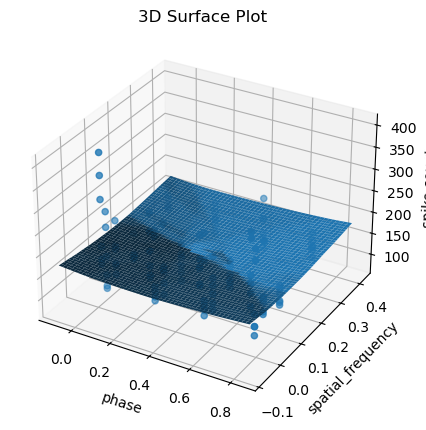

In [59]:
plot_regression_mlp_2D(df_neuron3, mlp_linear, 'phase', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

<Figure size 640x480 with 0 Axes>

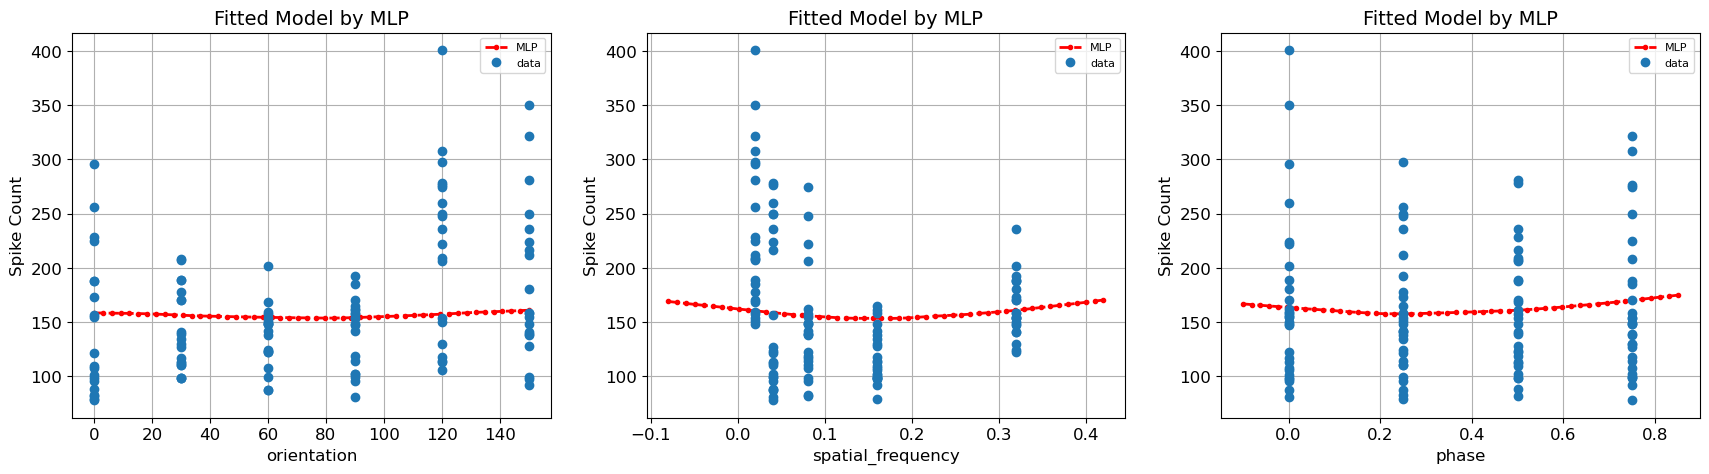

In [60]:
plot_regression_mlp_1D_all(df_neuron3, mlp_linear, orientation = 150, phase = 0.5, spatial_frequency= 0.32)

## Linear Regression

### First-Order Features

In [61]:
X_train_neuron3, X_test_neuron3, y_train_neuron3, y_test_neuron3 = get_data(df_neuron3)
res_order1 = OLS(y_train_neuron3, X_train_neuron3).fit()
print(res_order1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     3.662
Date:                Wed, 01 May 2024   Prob (F-statistic):             0.0158
Time:                        20:51:30   Log-Likelihood:                -461.54
No. Observations:                  84   AIC:                             931.1
Df Residuals:                      80   BIC:                             940.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        161.7540      6.606     24.485      0.0

In [62]:
final_features = backward_elimination(y_train_neuron3, X_train_neuron3)
print(f"Final model with significant features: {final_features}")
res_order1_improved = OLS(y_train_neuron3, X_train_neuron3[:, final_features]).fit()
print(res_order1_improved.summary())

Final model with significant features: [0, 1, 3]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     5.418
Date:                Wed, 01 May 2024   Prob (F-statistic):            0.00619
Time:                        20:51:30   Log-Likelihood:                -461.67
No. Observations:                  84   AIC:                             929.3
Df Residuals:                      81   BIC:                             936.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

R Squared: 0.118, Adjusted R Squared 0.096
Train RMSE: 63.177
Test RMSE: 56.698


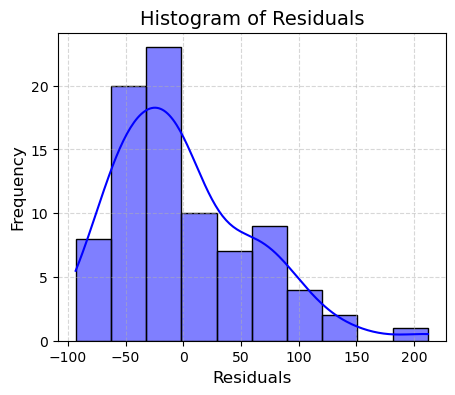

Final equation --> y = 161.58 + 18.77 * orient + -11.61 * freq


In [63]:
summary(res_order1_improved, final_features, X_test_neuron3, y_test_neuron3)

<Figure size 640x480 with 0 Axes>

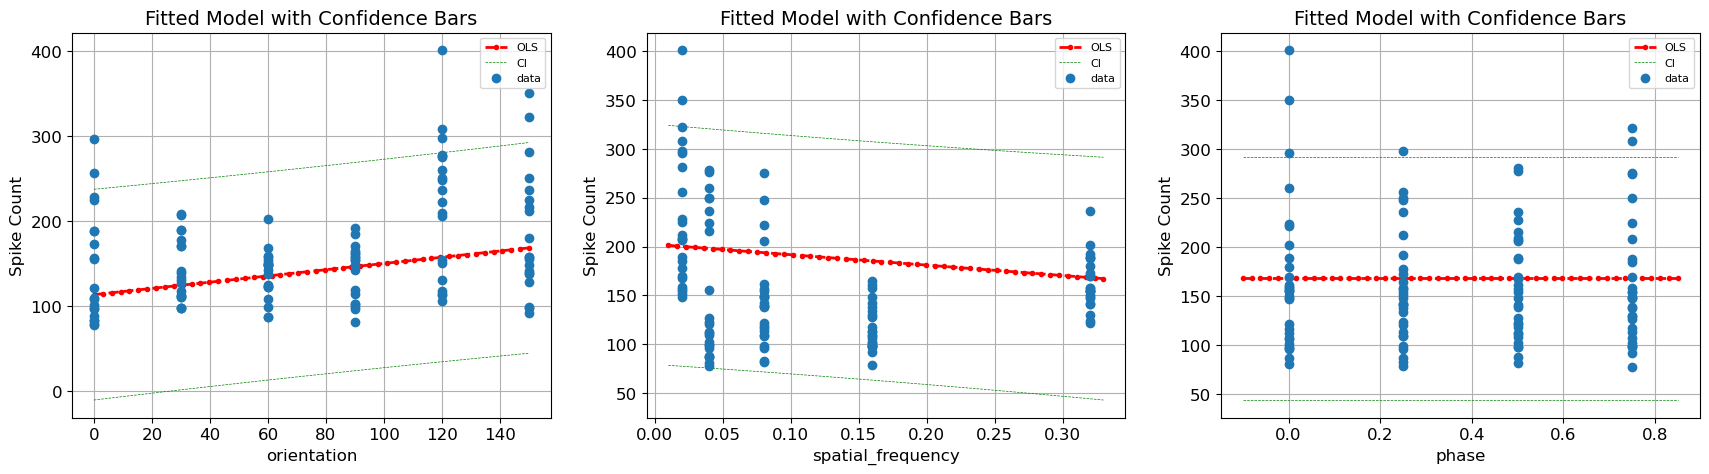

In [64]:
plot_regression_1D_all(df_neuron3, res_order1_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Quadratic Features

In [65]:
X_train_neuron3, X_test_neuron3, y_train_neuron3, y_test_neuron3 = get_data(df_neuron3, order=2)
res_order2 = OLS(y_train_neuron3, X_train_neuron3).fit()
print(res_order2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     6.156
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.98e-06
Time:                        20:51:31   Log-Likelihood:                -443.47
No. Observations:                  84   AIC:                             906.9
Df Residuals:                      74   BIC:                             931.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        163.5254      5.568     29.367      0.0

In [66]:
final_features = backward_elimination(y_train_neuron3, X_train_neuron3)
print(f"Final model with significant features: {final_features}")
res_order2_improved = OLS(y_train_neuron3, X_train_neuron3[:, final_features]).fit()
print(res_order2_improved.summary())

Final model with significant features: [0, 3, 4, 6, 9]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     13.91
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.24e-08
Time:                        20:51:32   Log-Likelihood:                -444.56
No. Observations:                  84   AIC:                             899.1
Df Residuals:                      79   BIC:                             911.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.413, Adjusted R Squared 0.383
Train RMSE: 63.177
Test RMSE: 43.695


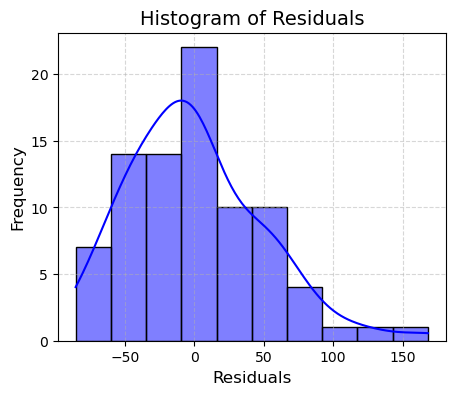

Final equation --> y = 162.95 + -119.82 * freq + 38.46 * orient^2 + -31.67 * (orient * freq) + 132.90 * freq^2


In [67]:
summary(res_order2_improved, final_features, X_test_neuron3, y_test_neuron3)

<Figure size 640x480 with 0 Axes>

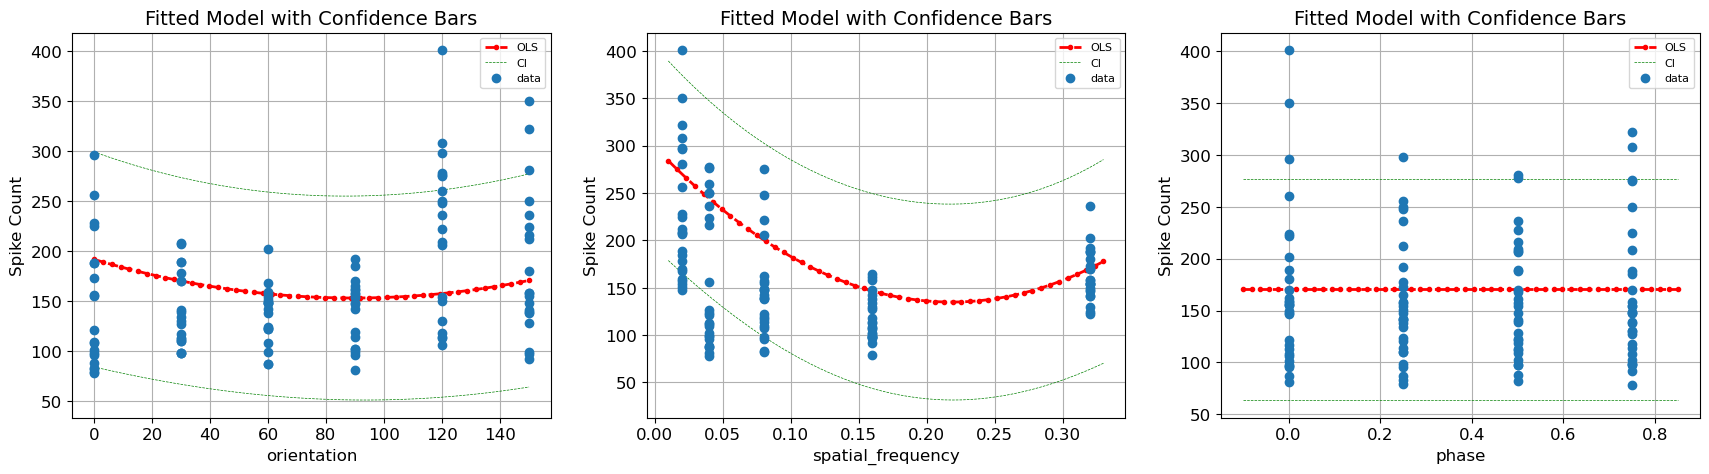

In [68]:
plot_regression_1D_all(df_neuron3, res_order2_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Sinusoidal Features

In [69]:
X_train_neuron3, X_test_neuron3, y_train_neuron3, y_test_neuron3 = get_data(df_neuron3, sinusoidal=True)
res_sinusoidal = OLS(y_train_neuron3, X_train_neuron3).fit()
print(res_sinusoidal.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     7.234
Date:                Wed, 01 May 2024   Prob (F-statistic):           3.81e-06
Time:                        20:51:33   Log-Likelihood:                -448.17
No. Observations:                  84   AIC:                             910.3
Df Residuals:                      77   BIC:                             927.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        160.4984      5.765     27.840      0.0

In [70]:
final_features = backward_elimination(y_train_neuron3, X_train_neuron3)
print(f"Final model with significant features: {final_features}")
res_sinusoidal_improved = OLS(y_train_neuron3, X_train_neuron3[:, final_features]).fit()
print(res_sinusoidal_improved.summary())

Final model with significant features: [0, 1, 3, 4, 6]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     10.65
Date:                Wed, 01 May 2024   Prob (F-statistic):           5.89e-07
Time:                        20:51:33   Log-Likelihood:                -448.83
No. Observations:                  84   AIC:                             907.7
Df Residuals:                      79   BIC:                             919.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.350, Adjusted R Squared 0.318
Train RMSE: 63.177
Test RMSE: 52.644


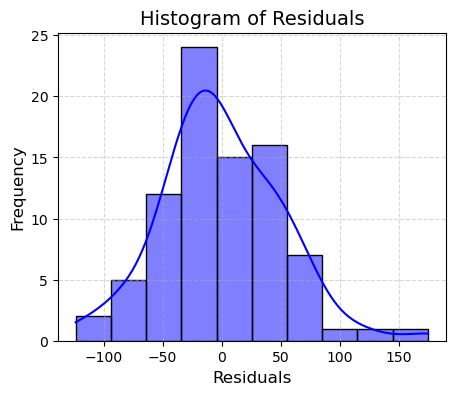

Final equation --> y = 160.00 + 11.26 * sin(orient) + -126.60 * sin(freq) + 19.40 * cos(orient) + -118.95 * cos(freq)


In [71]:
summary(res_sinusoidal_improved, final_features, X_test_neuron3, y_test_neuron3, sinusoidal = True)

<Figure size 640x480 with 0 Axes>

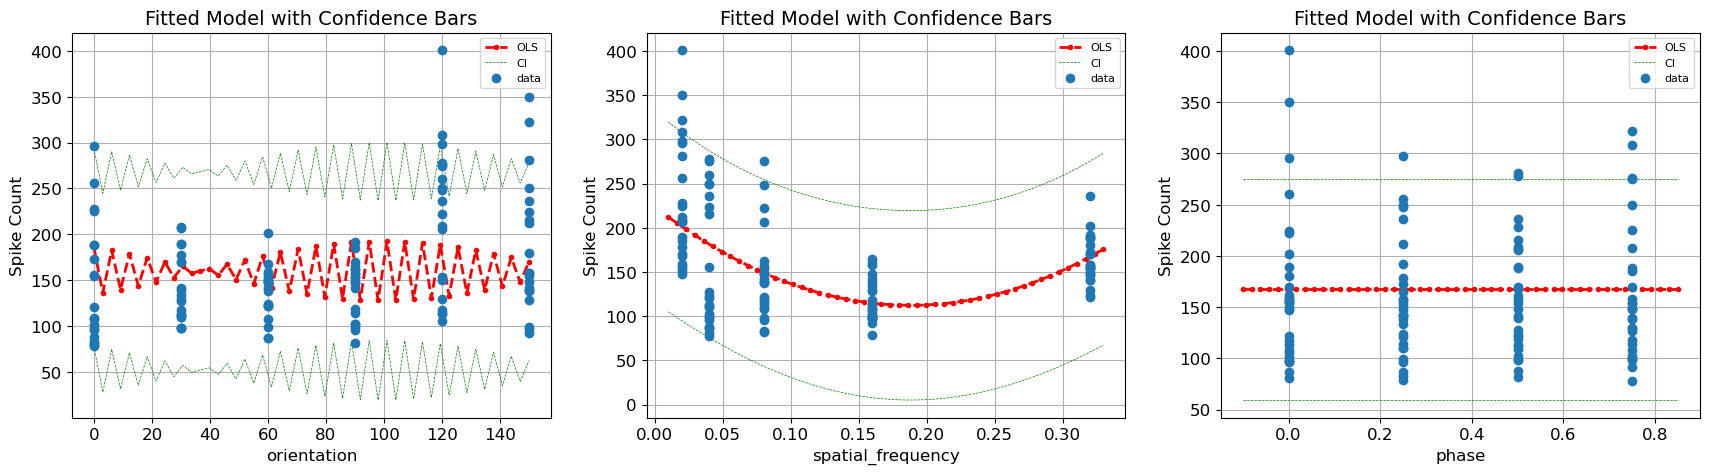

In [72]:
plot_regression_1D_all(df_neuron3, res_sinusoidal_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, sinusoidal=True)

### Combined Features

In [73]:
X_train_neuron3, X_test_neuron3, y_train_neuron3, y_test_neuron3 = get_data(df_neuron3, order=2, combined=True)
res_combined = OLS(y_train_neuron3, X_train_neuron3).fit()
print(res_combined.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     8.544
Date:                Wed, 01 May 2024   Prob (F-statistic):           2.56e-10
Time:                        20:51:34   Log-Likelihood:                -424.71
No. Observations:                  84   AIC:                             879.4
Df Residuals:                      69   BIC:                             915.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        163.8536      4.637     35.335      0.0

In [74]:
final_features = backward_elimination(y_train_neuron3, X_train_neuron3)
print(f"Final model with significant features: {final_features}")
res_combined_improved = OLS(y_train_neuron3, X_train_neuron3[:, final_features]).fit()
print(res_combined_improved.summary())

Final model with significant features: [0, 1, 3, 4, 6, 9, 12, 13, 15]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     15.12
Date:                Wed, 01 May 2024   Prob (F-statistic):           5.76e-13
Time:                        20:51:35   Log-Likelihood:                -426.60
No. Observations:                  84   AIC:                             871.2
Df Residuals:                      75   BIC:                             893.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

R Squared: 0.617, Adjusted R Squared 0.576
Train RMSE: 63.177
Test RMSE: 43.070


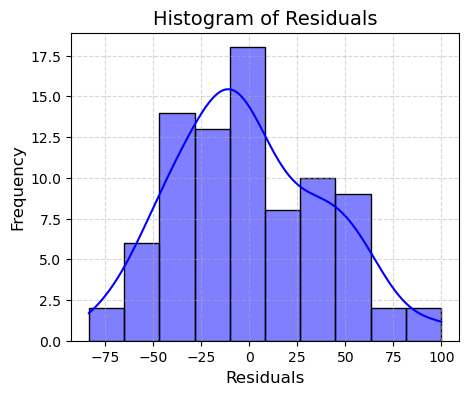

Final equation --> y = 163.28 + 117.55 * orient + -610084.20 * freq + -85.01 * orient^2 + -34.81 * (orient * freq) + 731275.83 * freq^2 + 597739.80 * sin(freq) + 39.09 * cos(orient) + 718332.99 * cos(freq)


In [75]:
summary(res_combined_improved, final_features, X_test_neuron3, y_test_neuron3)

<Figure size 640x480 with 0 Axes>

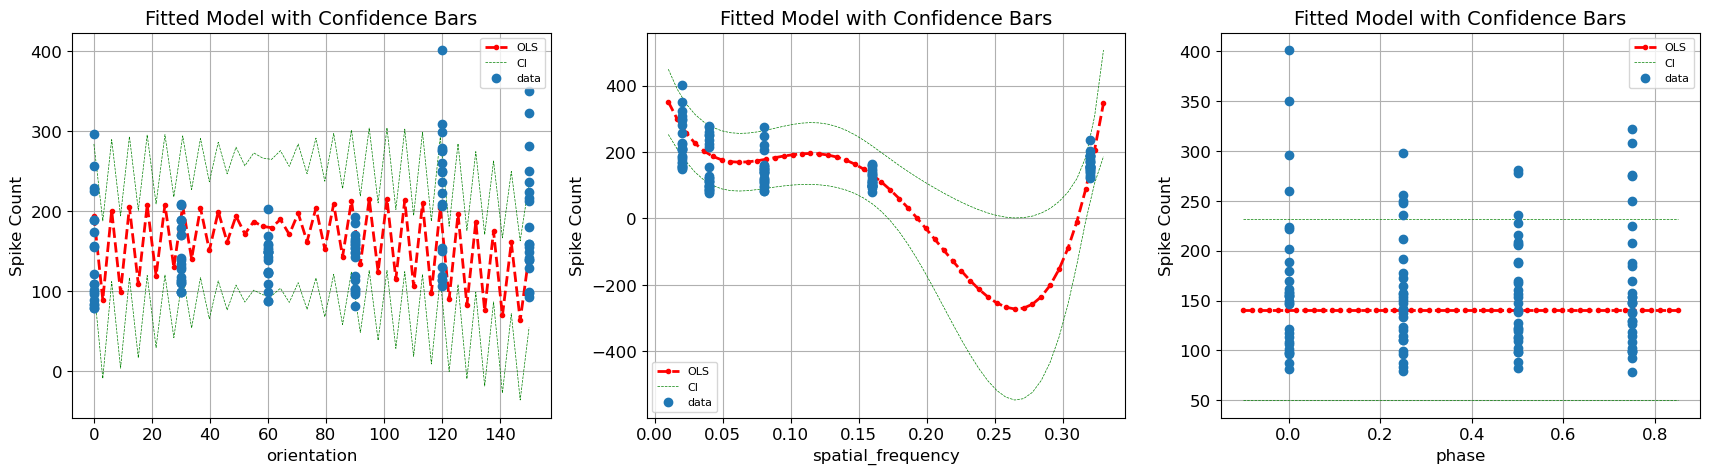

In [76]:
plot_regression_1D_all(df_neuron3, res_combined_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, order = 2, combined = True)

Wrong since values go below zero.

# Neuron 4

In [77]:
df_neuron4 = dfs[3]
df_neuron4

unit_id  spike_count  orientation  phase  spatial_frequency
4    951093928           35        150.0   0.50               0.02
10   951093928          243          0.0   0.50               0.16
16   951093928          144         30.0   0.25               0.04
22   951093928           30         60.0   0.75               0.04
28   951093928           73         60.0   0.00               0.08
..         ...          ...          ...    ...                ...
700  951093928          179        150.0   0.25               0.32
706  951093928           24         90.0   0.50               0.04
712  951093928          243          0.0   0.00               0.16
718  951093928          190         30.0   0.50               0.32
724  951093928           33         90.0   0.25               0.02

[120 rows x 5 columns]

## MLP

c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Epoch 1	Train loss: 145.6279525756836	Test loss: 135.0673065185547
Epoch 2	Train loss: 140.60092163085938	Test loss: 135.01148986816406
Epoch 3	Train loss: 134.35274505615234	Test loss: 134.9294891357422
Epoch 4	Train loss: 126.93474578857422	Test loss: 134.7676239013672
Epoch 5	Train loss: 139.4990997314453	Test loss: 134.39169311523438
Epoch 6	Train loss: 131.65144729614258	Test loss: 133.4215087890625
Epoch 7	Train loss: 118.31993103027344	Test loss: 130.85543823242188
Epoch 8	Train loss: 130.74738693237305	Test loss: 124.39994049072266
Epoch 9	Train loss: 127.99402618408203	Test loss: 109.61890411376953
Epoch 10	Train loss: 102.50586700439453	Test loss: 88.03226470947266
Epoch 11	Train loss: 91.98898315429688	Test loss: 106.93077850341797
Epoch 12	Train loss: 99.76556015014648	Test loss: 88.7928237915039
Epoch 13	Train loss: 83.62949752807617	Test loss: 88.47681427001953
Epoch 14	Train loss: 85.7906608581543	Test loss: 91.22669982910156
Epoch 15	Train loss: 87.64535140991211	Test l

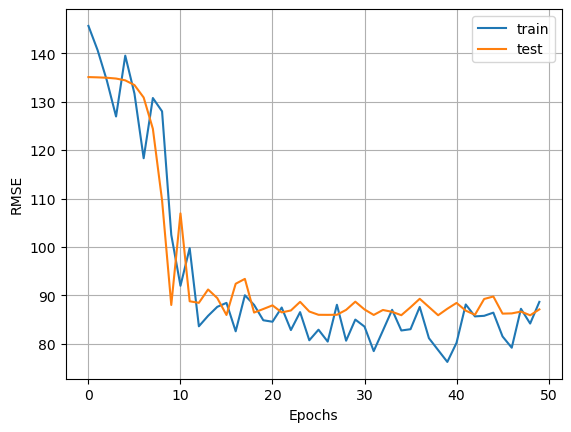

In [78]:
mlp_linear = run_mlp(df_neuron4)

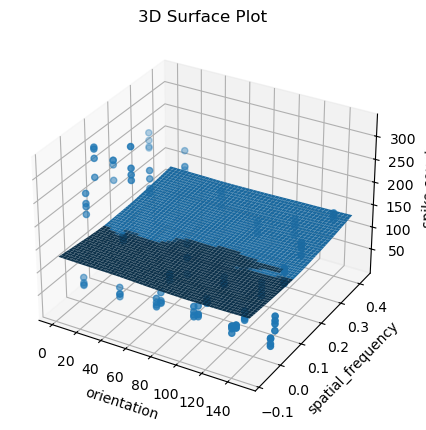

In [79]:
plot_regression_mlp_2D(df_neuron4, mlp_linear, 'orientation', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

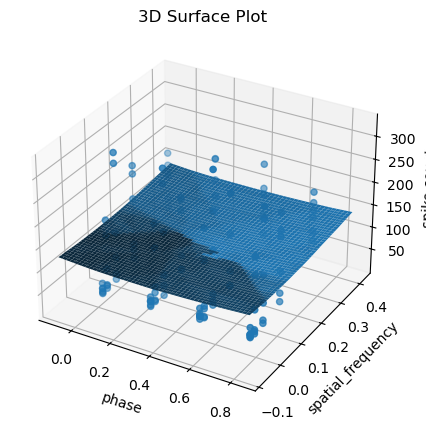

In [80]:
plot_regression_mlp_2D(df_neuron4, mlp_linear, 'phase', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

<Figure size 640x480 with 0 Axes>

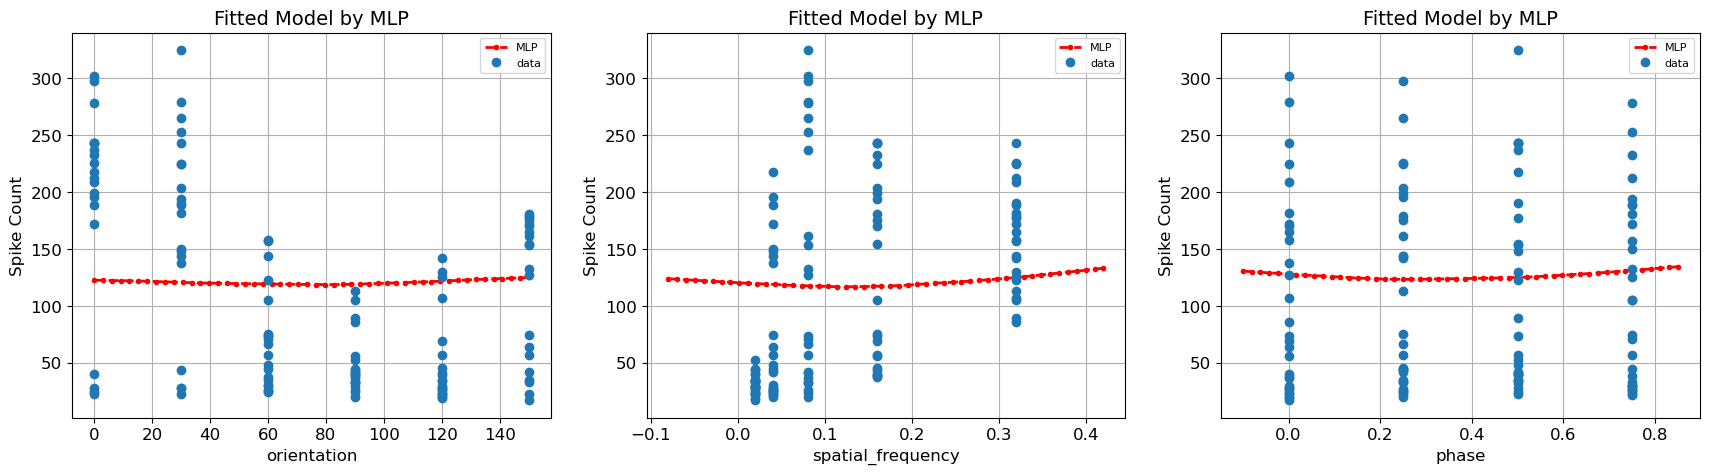

In [81]:
plot_regression_mlp_1D_all(df_neuron4, mlp_linear, orientation = 150, phase = 0.5, spatial_frequency= 0.32)

## Linear Regression

### First-Order Features

In [82]:
X_train_neuron4, X_test_neuron4, y_train_neuron4, y_test_neuron4 = get_data(df_neuron4)
res_order1 = OLS(y_train_neuron4, X_train_neuron4).fit()
print(res_order1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     15.27
Date:                Wed, 01 May 2024   Prob (F-statistic):           6.06e-08
Time:                        20:51:44   Log-Likelihood:                -471.12
No. Observations:                  84   AIC:                             950.2
Df Residuals:                      80   BIC:                             960.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.0082      7.404     14.453      0.0

In [83]:
final_features = backward_elimination(y_train_neuron4, X_train_neuron4)
print(f"Final model with significant features: {final_features}")
res_order1_improved = OLS(y_train_neuron4, X_train_neuron4[:, final_features]).fit()
print(res_order1_improved.summary())

Final model with significant features: [0, 1, 3]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     23.03
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.21e-08
Time:                        20:51:44   Log-Likelihood:                -471.22
No. Observations:                  84   AIC:                             948.4
Df Residuals:                      81   BIC:                             955.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

R Squared: 0.363, Adjusted R Squared 0.347
Train RMSE: 83.257
Test RMSE: 63.649


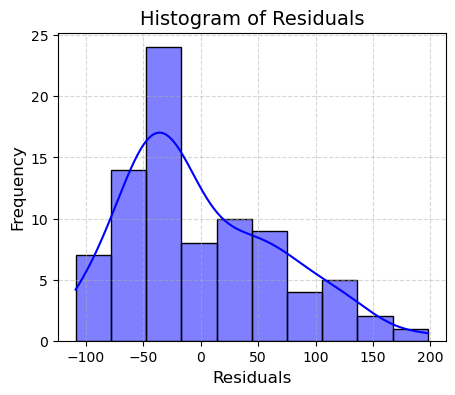

Final equation --> y = 107.18 + -38.27 * orient + 33.79 * freq


In [84]:
summary(res_order1_improved, final_features, X_test_neuron4, y_test_neuron4)

<Figure size 640x480 with 0 Axes>

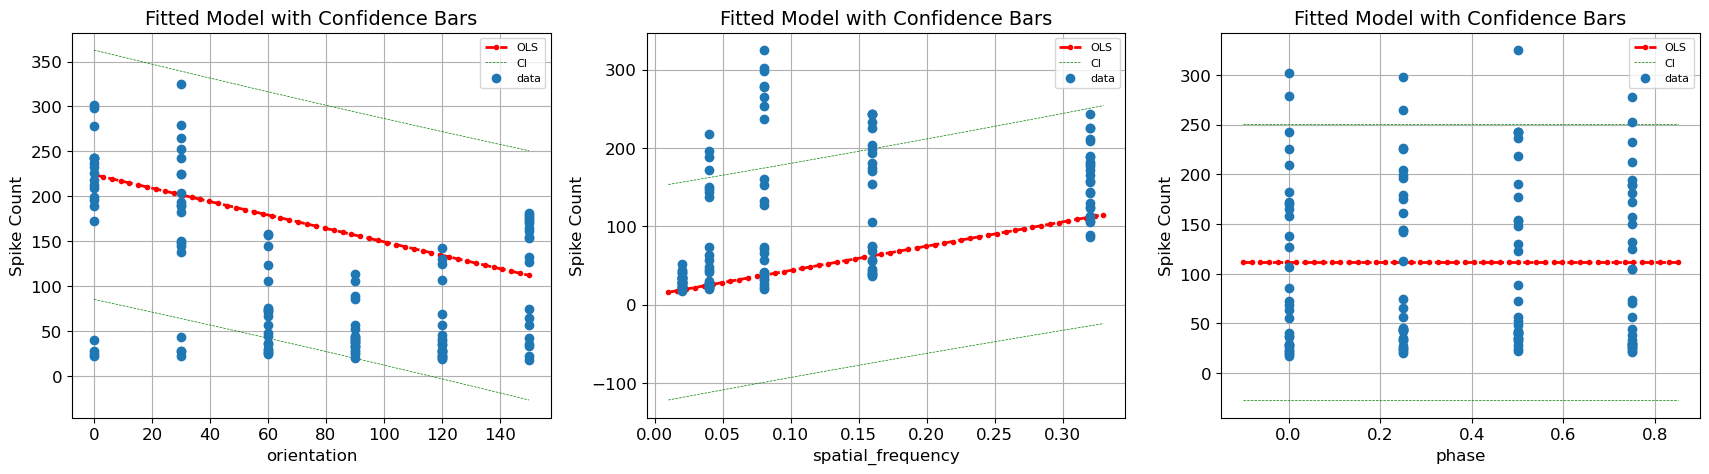

In [85]:
plot_regression_1D_all(df_neuron4, res_order1_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Quadratic Features

In [86]:
X_train_neuron4, X_test_neuron4, y_train_neuron4, y_test_neuron4 = get_data(df_neuron4, order=2)
res_order2 = OLS(y_train_neuron4, X_train_neuron4).fit()
print(res_order2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     13.17
Date:                Wed, 01 May 2024   Prob (F-statistic):           2.73e-12
Time:                        20:51:45   Log-Likelihood:                -449.97
No. Observations:                  84   AIC:                             919.9
Df Residuals:                      74   BIC:                             944.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.3032      6.016     17.670      0.0

In [87]:
final_features = backward_elimination(y_train_neuron4, X_train_neuron4)
print(f"Final model with significant features: {final_features}")
res_order2_improved = OLS(y_train_neuron4, X_train_neuron4[:, final_features]).fit()
print(res_order2_improved.summary())

Final model with significant features: [0, 1, 3, 4, 9]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     29.72
Date:                Wed, 01 May 2024   Prob (F-statistic):           4.39e-15
Time:                        20:51:45   Log-Likelihood:                -451.57
No. Observations:                  84   AIC:                             913.1
Df Residuals:                      79   BIC:                             925.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.601, Adjusted R Squared 0.581
Train RMSE: 83.257
Test RMSE: 44.652


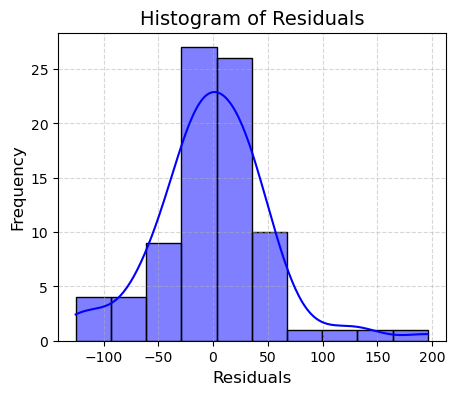

Final equation --> y = 107.20 + -153.50 * orient + 132.18 * freq + 122.99 * orient^2 + -98.14 * freq^2


In [88]:
summary(res_order2_improved, final_features, X_test_neuron4, y_test_neuron4)

<Figure size 640x480 with 0 Axes>

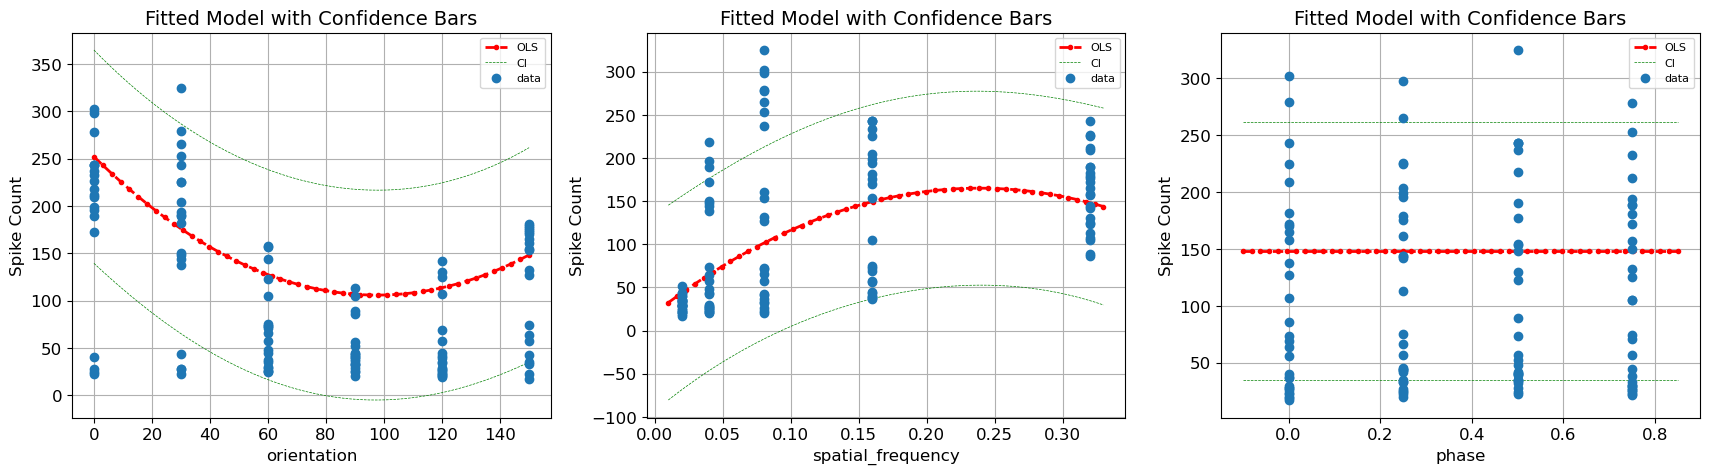

In [89]:
plot_regression_1D_all(df_neuron4, res_order2_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Sinusoidal Features

In [90]:
X_train_neuron4, X_test_neuron4, y_train_neuron4, y_test_neuron4 = get_data(df_neuron4, sinusoidal=True)
res_sinusoidal = OLS(y_train_neuron4, X_train_neuron4).fit()
print(res_sinusoidal.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     15.08
Date:                Wed, 01 May 2024   Prob (F-statistic):           2.46e-11
Time:                        20:51:47   Log-Likelihood:                -457.49
No. Observations:                  84   AIC:                             929.0
Df Residuals:                      77   BIC:                             946.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.6988      6.441     17.186      0.0

In [91]:
final_features = backward_elimination(y_train_neuron4, X_train_neuron4)
print(f"Final model with significant features: {final_features}")
res_sinusoidal_improved = OLS(y_train_neuron4, X_train_neuron4[:, final_features]).fit()
print(res_sinusoidal_improved.summary())

Final model with significant features: [0, 1, 2, 3, 4, 5, 6]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     15.08
Date:                Wed, 01 May 2024   Prob (F-statistic):           2.46e-11
Time:                        20:51:47   Log-Likelihood:                -457.49
No. Observations:                  84   AIC:                             929.0
Df Residuals:                      77   BIC:                             946.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

R Squared: 0.540, Adjusted R Squared 0.505
Train RMSE: 83.257
Test RMSE: 64.832


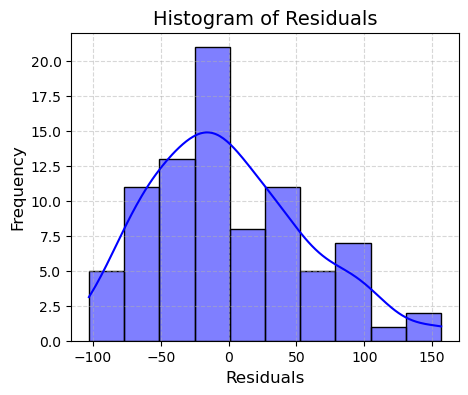

Final equation --> y = 110.70 + -36.42 * sin(orient) + 37.20 * sin(phase) + 116.61 * sin(freq) + 25.14 * cos(orient) + 34.41 * cos(phase) + 83.12 * cos(freq)


In [92]:
summary(res_sinusoidal_improved, final_features, X_test_neuron4, y_test_neuron4, sinusoidal = True)

<Figure size 640x480 with 0 Axes>

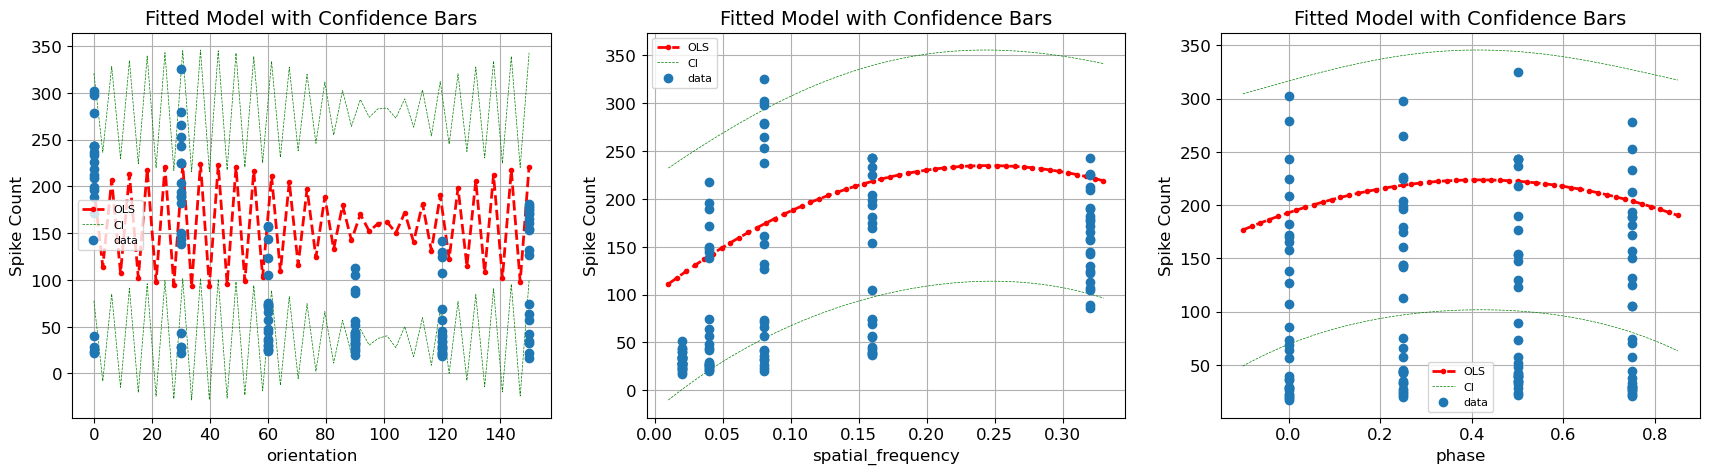

In [93]:
plot_regression_1D_all(df_neuron4, res_sinusoidal_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, sinusoidal=True)

### Combined Features

In [94]:
X_train_neuron4, X_test_neuron4, y_train_neuron4, y_test_neuron4 = get_data(df_neuron4, order=2, combined=True)
res_combined = OLS(y_train_neuron4, X_train_neuron4).fit()
print(res_combined.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     13.11
Date:                Wed, 01 May 2024   Prob (F-statistic):           2.39e-14
Time:                        20:51:48   Log-Likelihood:                -435.64
No. Observations:                  84   AIC:                             901.3
Df Residuals:                      69   BIC:                             937.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.5252      5.282     20.358      0.0

In [95]:
final_features = backward_elimination(y_train_neuron4, X_train_neuron4)
print(f"Final model with significant features: {final_features}")
res_combined_improved = OLS(y_train_neuron4, X_train_neuron4[:, final_features]).fit()
print(res_combined_improved.summary())

Final model with significant features: [0, 1, 3, 4, 9, 10, 12]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     31.47
Date:                Wed, 01 May 2024   Prob (F-statistic):           7.93e-19
Time:                        20:51:48   Log-Likelihood:                -438.09
No. Observations:                  84   AIC:                             890.2
Df Residuals:                      77   BIC:                             907.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

R Squared: 0.710, Adjusted R Squared 0.688
Train RMSE: 83.257
Test RMSE: 37.195


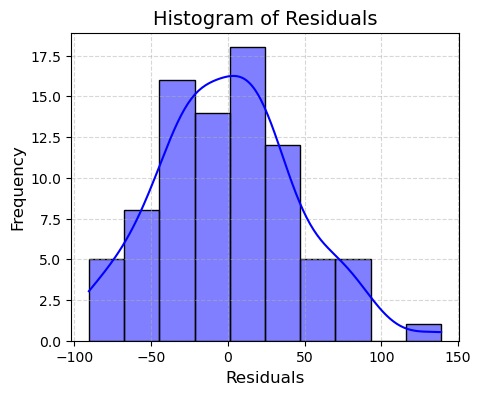

Final equation --> y = 108.39 + -126.56 * orient + 29331.50 * freq + 98.01 * orient^2 + -922.14 * freq^2 + -22.05 * sin(orient) + -28396.11 * sin(freq)


In [96]:
summary(res_combined_improved, final_features, X_test_neuron4, y_test_neuron4)

<Figure size 640x480 with 0 Axes>

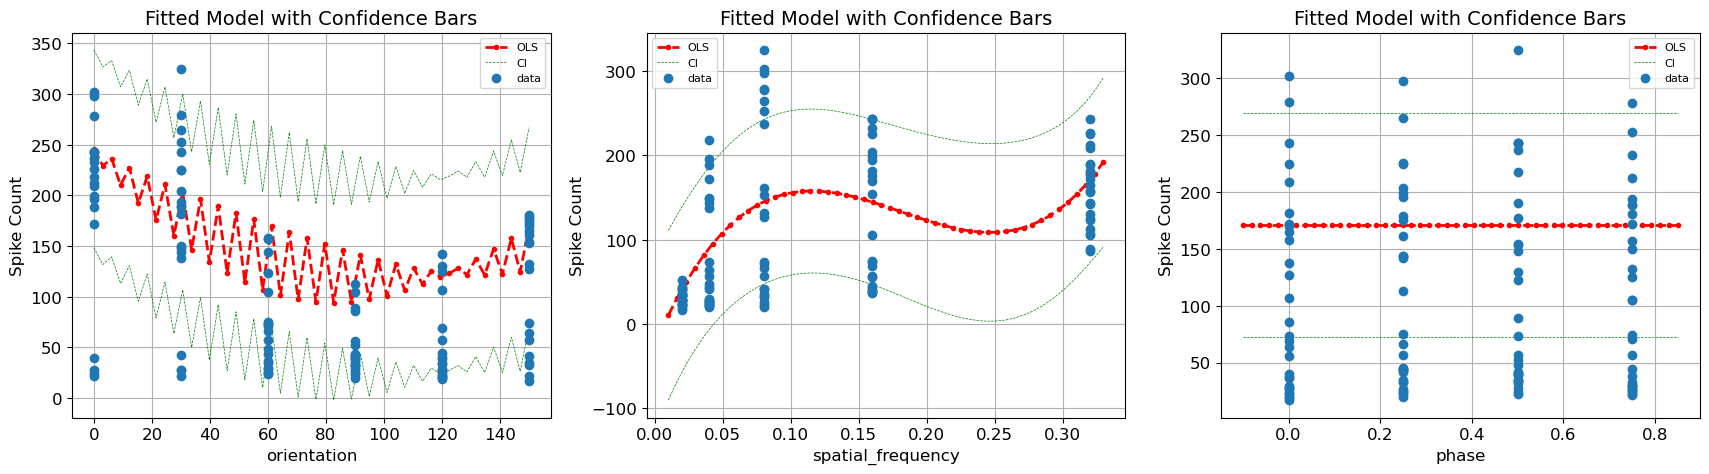

In [97]:
plot_regression_1D_all(df_neuron4, res_combined_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, order = 2, combined = True)

# Neuron 5

In [98]:
df_neuron5 = dfs[4]
df_neuron5

unit_id  spike_count  orientation  phase  spatial_frequency
5    951098242           38        150.0   0.50               0.02
11   951098242          271          0.0   0.50               0.16
17   951098242          148         30.0   0.25               0.04
23   951098242           38         60.0   0.75               0.04
29   951098242           75         60.0   0.00               0.08
..         ...          ...          ...    ...                ...
701  951098242          101        150.0   0.25               0.32
707  951098242           22         90.0   0.50               0.04
713  951098242          269          0.0   0.00               0.16
719  951098242           83         30.0   0.50               0.32
725  951098242           29         90.0   0.25               0.02

[120 rows x 5 columns]

## MLP

c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sandr\anaconda3\envs\neuro\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Epoch 1	Train loss: 146.2547836303711	Test loss: 153.28585815429688
Epoch 2	Train loss: 150.01862335205078	Test loss: 153.23501586914062
Epoch 3	Train loss: 143.9389877319336	Test loss: 153.16212463378906
Epoch 4	Train loss: 136.6555290222168	Test loss: 153.0222930908203
Epoch 5	Train loss: 143.3789520263672	Test loss: 152.70645141601562
Epoch 6	Train loss: 142.09153747558594	Test loss: 151.90733337402344
Epoch 7	Train loss: 116.84464263916016	Test loss: 149.80682373046875
Epoch 8	Train loss: 139.3130874633789	Test loss: 144.416259765625
Epoch 9	Train loss: 138.93863677978516	Test loss: 131.78567504882812
Epoch 10	Train loss: 120.1502685546875	Test loss: 110.01023864746094
Epoch 11	Train loss: 99.8895149230957	Test loss: 125.61318969726562
Epoch 12	Train loss: 118.35520935058594	Test loss: 109.06148529052734
Epoch 13	Train loss: 100.01113891601562	Test loss: 107.59029388427734
Epoch 14	Train loss: 99.92129135131836	Test loss: 112.30915069580078
Epoch 15	Train loss: 108.38940048217773	T

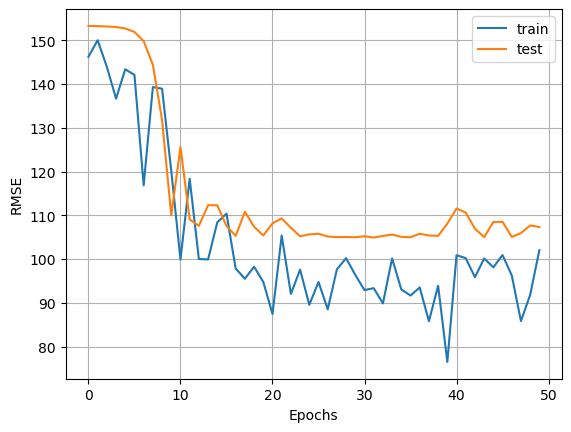

In [99]:
mlp_linear = run_mlp(df_neuron5)

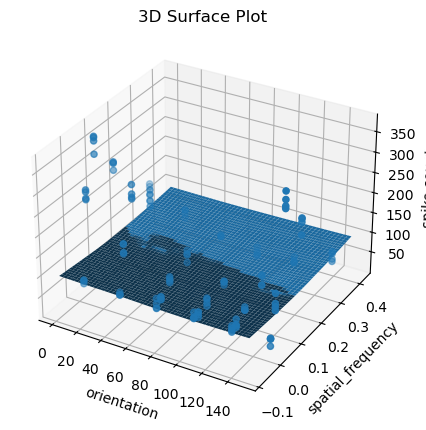

In [100]:
plot_regression_mlp_2D(df_neuron5, mlp_linear, 'orientation', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

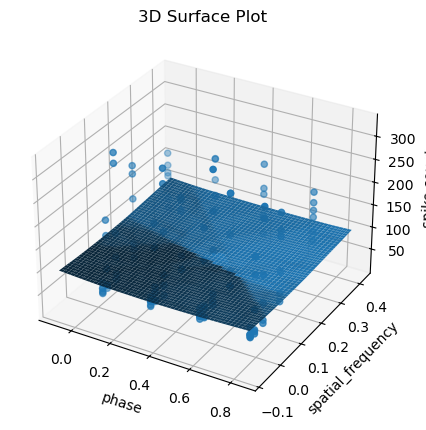

In [101]:
plot_regression_mlp_2D(df_neuron4, mlp_linear, 'phase', 'spatial_frequency', orientation = 150, phase = 0.5, spatial_frequency= 0.32)

<Figure size 640x480 with 0 Axes>

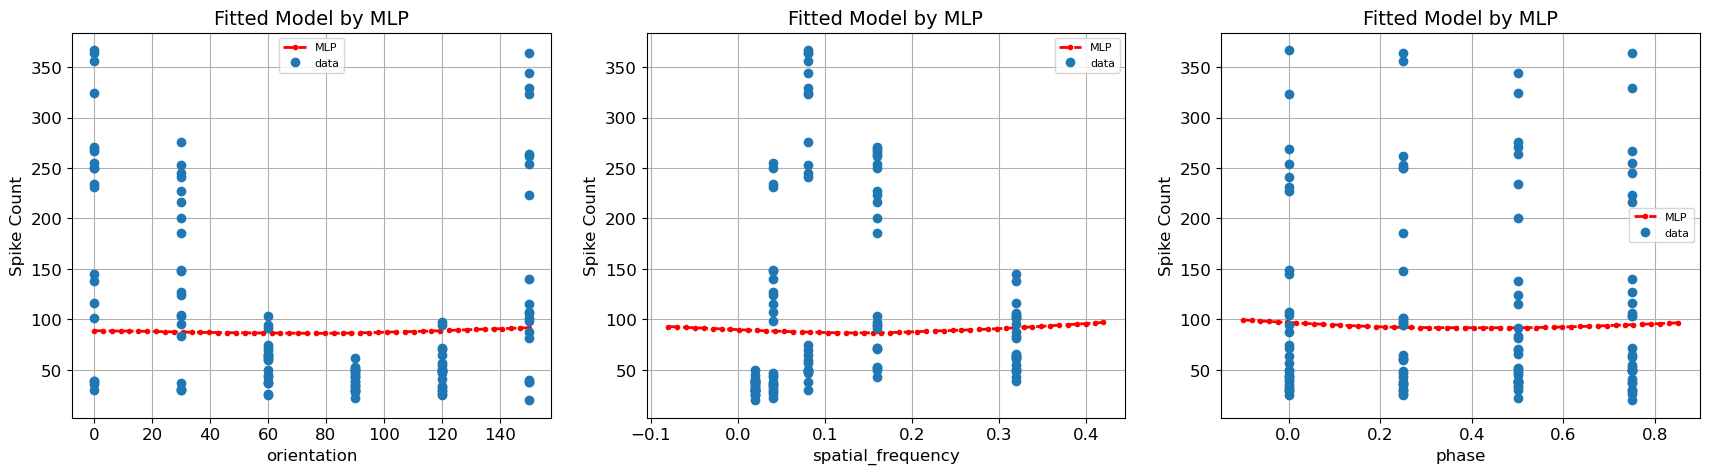

In [102]:
plot_regression_mlp_1D_all(df_neuron5, mlp_linear, orientation = 150, phase = 0.5, spatial_frequency= 0.32)

## Linear Regression

### First-Order Features

In [103]:
X_train_neuron5, X_test_neuron5, y_train_neuron5, y_test_neuron5 = get_data(df_neuron5)
res_order1 = OLS(y_train_neuron5, X_train_neuron5).fit()
print(res_order1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.239
Date:                Wed, 01 May 2024   Prob (F-statistic):             0.0901
Time:                        20:51:58   Log-Likelihood:                -497.15
No. Observations:                  84   AIC:                             1002.
Df Residuals:                      80   BIC:                             1012.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        109.1462     10.094     10.813      0.0

In [104]:
final_features = backward_elimination(y_train_neuron5, X_train_neuron5)
print(f"Final model with significant features: {final_features}")
res_order1_improved = OLS(y_train_neuron5, X_train_neuron5[:, final_features]).fit()
print(res_order1_improved.summary())

Final model with significant features: [0, 1]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     6.790
Date:                Wed, 01 May 2024   Prob (F-statistic):             0.0109
Time:                        20:51:58   Log-Likelihood:                -497.20
No. Observations:                  84   AIC:                             998.4
Df Residuals:                      82   BIC:                             1003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

R Squared: 0.076, Adjusted R Squared 0.065
Train RMSE: 94.238
Test RMSE: 103.424


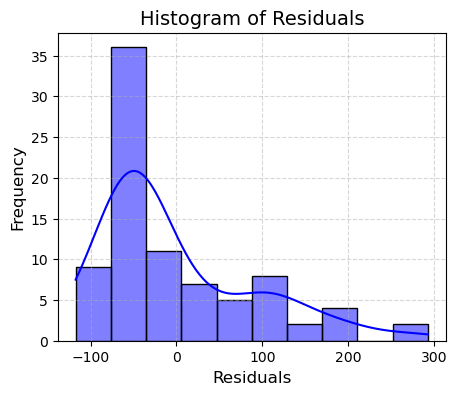

Final equation --> y = 109.29 + -26.06 * orient


In [105]:
summary(res_order1_improved, final_features, X_test_neuron5, y_test_neuron5)

<Figure size 640x480 with 0 Axes>

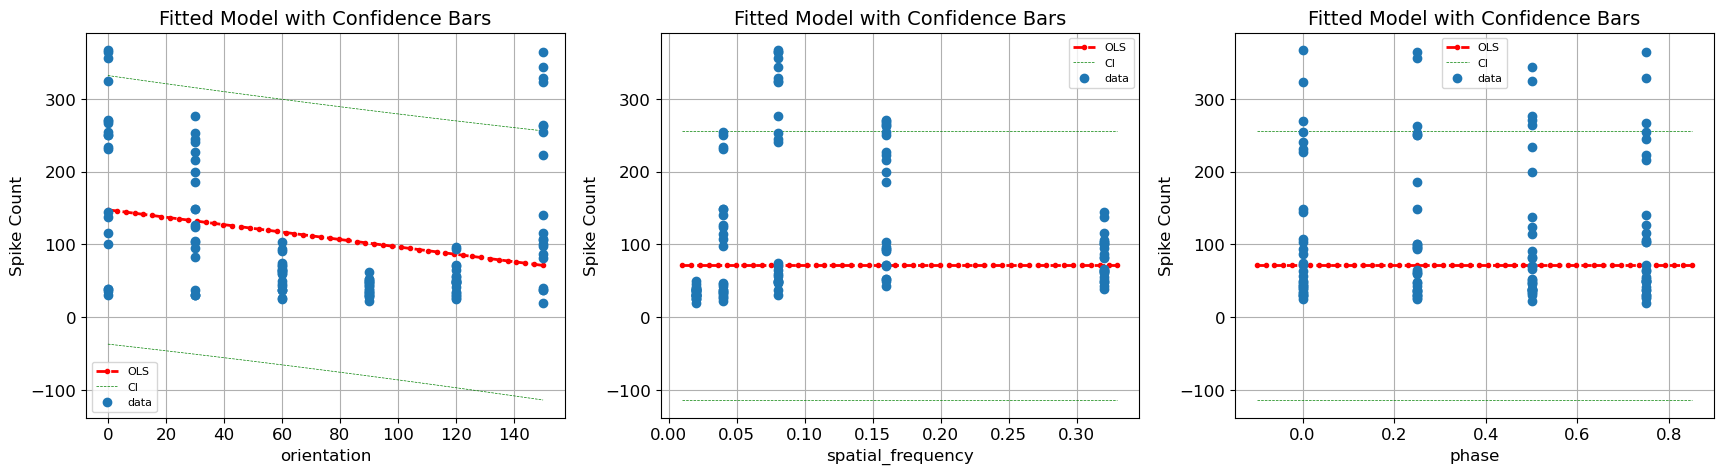

In [106]:
plot_regression_1D_all(df_neuron5, res_order1_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Quadratic Features

In [107]:
X_train_neuron5, X_test_neuron5, y_train_neuron5, y_test_neuron5 = get_data(df_neuron5, order=2)
res_order2 = OLS(y_train_neuron5, X_train_neuron5).fit()
print(res_order2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     12.43
Date:                Wed, 01 May 2024   Prob (F-statistic):           9.29e-12
Time:                        20:51:59   Log-Likelihood:                -461.86
No. Observations:                  84   AIC:                             943.7
Df Residuals:                      74   BIC:                             968.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.5232      6.930     15.659      0.0

In [108]:
final_features = backward_elimination(y_train_neuron5, X_train_neuron5)
print(f"Final model with significant features: {final_features}")
res_order2_improved = OLS(y_train_neuron5, X_train_neuron5[:, final_features]).fit()
print(res_order2_improved.summary())

Final model with significant features: [0, 1, 3, 4, 9]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     29.16
Date:                Wed, 01 May 2024   Prob (F-statistic):           6.81e-15
Time:                        20:51:59   Log-Likelihood:                -462.45
No. Observations:                  84   AIC:                             934.9
Df Residuals:                      79   BIC:                             947.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.596, Adjusted R Squared 0.576
Train RMSE: 94.238
Test RMSE: 60.493


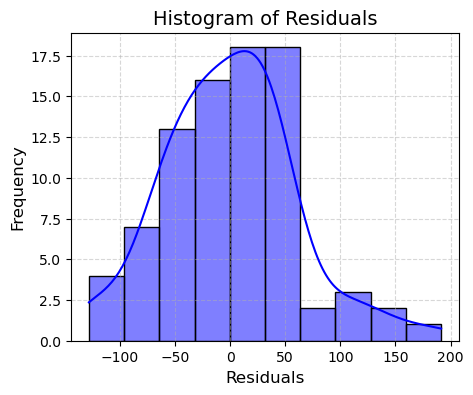

Final equation --> y = 109.02 + -196.53 * orient + 203.39 * freq + 181.36 * orient^2 + -204.41 * freq^2


In [109]:
summary(res_order2_improved, final_features, X_test_neuron5, y_test_neuron5)

<Figure size 640x480 with 0 Axes>

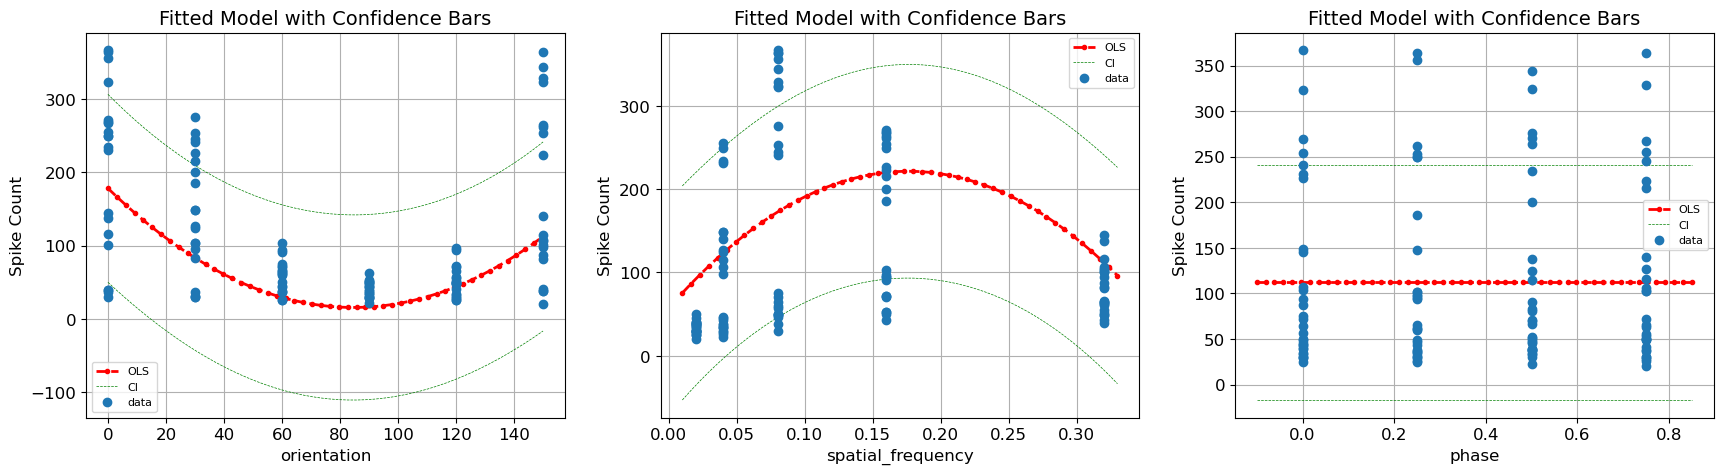

In [110]:
plot_regression_1D_all(df_neuron5, res_order2_improved, final_features, orientation = 150, phase = 0.5, spatial_frequency = 0.32, order = 2)

### Sinusoidal Features

In [111]:
X_train_neuron5, X_test_neuron5, y_train_neuron5, y_test_neuron5 = get_data(df_neuron5, sinusoidal=True)
res_sinusoidal = OLS(y_train_neuron5, X_train_neuron5).fit()
print(res_sinusoidal.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     15.65
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.18e-11
Time:                        20:52:01   Log-Likelihood:                -467.06
No. Observations:                  84   AIC:                             948.1
Df Residuals:                      77   BIC:                             965.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.9476      7.219     15.508      0.0

In [112]:
final_features = backward_elimination(y_train_neuron5, X_train_neuron5)
print(f"Final model with significant features: {final_features}")
res_sinusoidal_improved = OLS(y_train_neuron5, X_train_neuron5[:, final_features]).fit()
print(res_sinusoidal_improved.summary())

Final model with significant features: [0, 1, 3, 4, 6]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     23.58
Date:                Wed, 01 May 2024   Prob (F-statistic):           7.49e-13
Time:                        20:52:01   Log-Likelihood:                -467.54
No. Observations:                  84   AIC:                             945.1
Df Residuals:                      79   BIC:                             957.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R Squared: 0.544, Adjusted R Squared 0.521
Train RMSE: 94.238
Test RMSE: 72.190


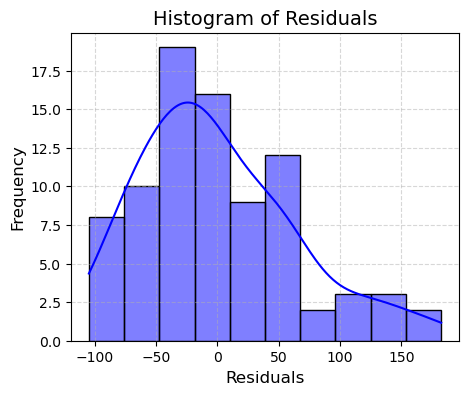

Final equation --> y = 112.50 + -36.40 * sin(orient) + 185.06 * sin(freq) + 35.52 * cos(orient) + 185.80 * cos(freq)


In [113]:
summary(res_sinusoidal_improved, final_features, X_test_neuron5, y_test_neuron5, sinusoidal = True)

<Figure size 640x480 with 0 Axes>

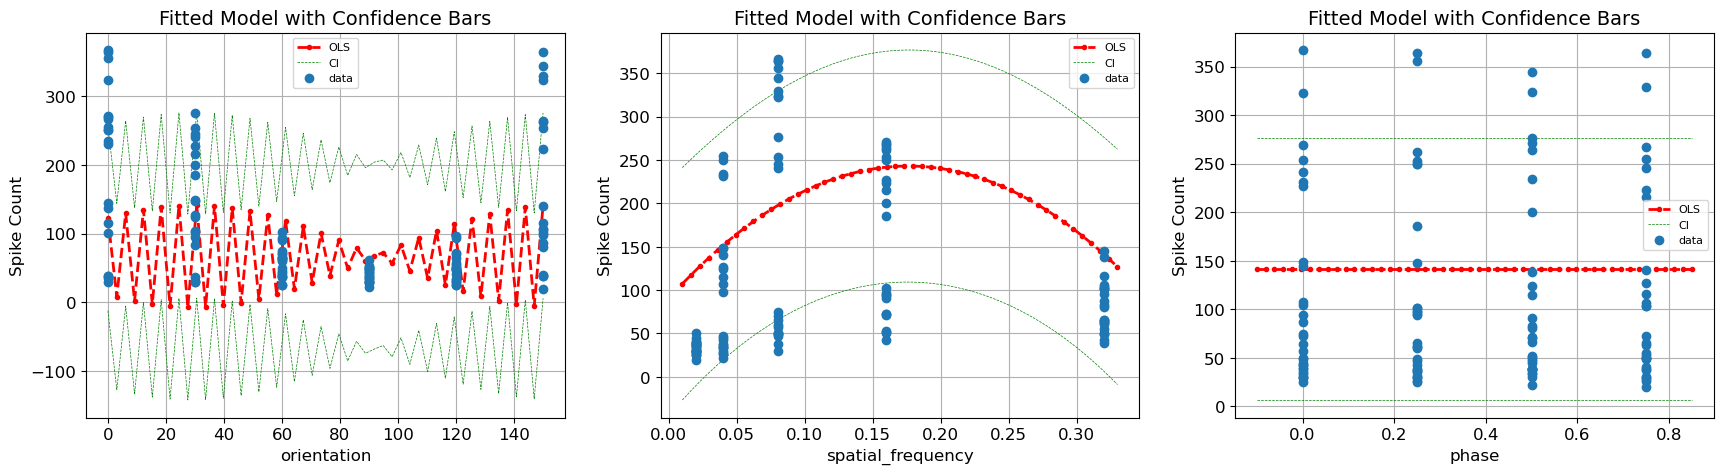

In [114]:
plot_regression_1D_all(df_neuron5, res_sinusoidal_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, sinusoidal=True)

### Combined Features

In [115]:
X_train_neuron5, X_test_neuron5, y_train_neuron5, y_test_neuron5 = get_data(df_neuron5, order=2, combined=True)
res_combined = OLS(y_train_neuron5, X_train_neuron5).fit()
print(res_combined.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     11.45
Date:                Wed, 01 May 2024   Prob (F-statistic):           5.36e-13
Time:                        20:52:02   Log-Likelihood:                -450.11
No. Observations:                  84   AIC:                             930.2
Df Residuals:                      69   BIC:                             966.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        109.3376      6.274     17.426      0.0

In [116]:
final_features = backward_elimination(y_train_neuron5, X_train_neuron5)
print(f"Final model with significant features: {final_features}")
res_combined_improved = OLS(y_train_neuron5, X_train_neuron5[:, final_features]).fit()
print(res_combined_improved.summary())

Final model with significant features: [0, 1, 3, 4, 9, 10, 12]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     28.89
Date:                Wed, 01 May 2024   Prob (F-statistic):           7.56e-18
Time:                        20:52:02   Log-Likelihood:                -451.01
No. Observations:                  84   AIC:                             916.0
Df Residuals:                      77   BIC:                             933.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

R Squared: 0.692, Adjusted R Squared 0.668
Train RMSE: 94.238
Test RMSE: 49.803


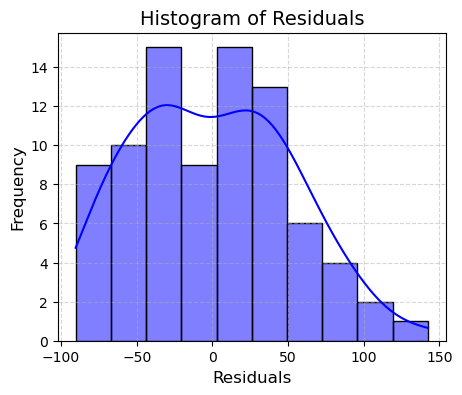

Final equation --> y = 109.85 + -174.47 * orient + 36678.44 * freq + 160.82 * orient^2 + -1236.34 * freq^2 + -19.53 * sin(orient) + -35469.31 * sin(freq)


In [117]:
summary(res_combined_improved, final_features, X_test_neuron5, y_test_neuron5)

<Figure size 640x480 with 0 Axes>

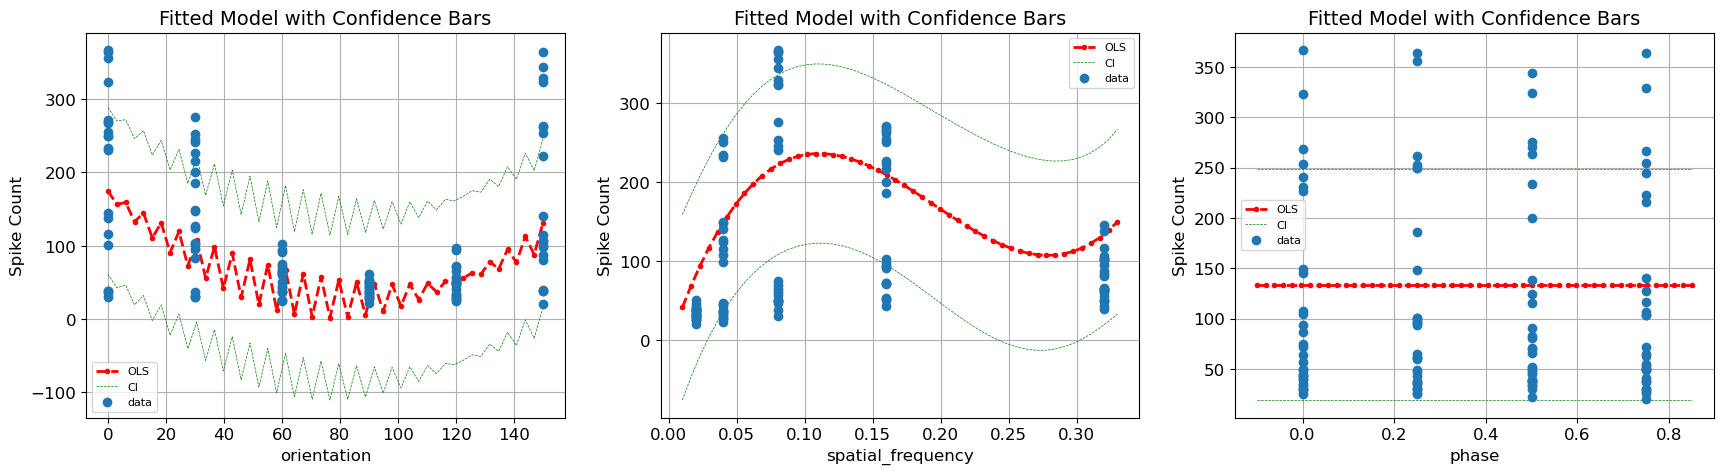

In [118]:
plot_regression_1D_all(df_neuron5, res_combined_improved, final_features, spatial_frequency = 0.32, orientation = 150, phase = 0.5, order = 2, combined = True)

# Comments

## MLP

 - Neuron 1 --> Train loss: 35.63, Test loss: 40.36
 - Neuron 2 --> Train loss: 74.08, Test loss: 65.36
 - Neuron 3 --> Train loss: 62.21, Test loss: 64.66
 - Neuron 4 --> Train loss: 88.67, Test loss: 87.12
 - Neuron 5 --> Train loss: 102.02, Test loss: 107.30

 Performance is bad like in range case. Here test loss is higher, so it confirms the fact that in the range case test loss was lower simply because of the samples in the test set.

## Regression

**Neuron 1**
- linear:
    - $y = 367.61 + 10.27 orient$
    - R Squared: 0.085, Adjusted R Squared 0.074, Train RMSE: 35.181, Test RMSE: 37.292
    - depends only on orientation, but orientation seems more oscillatory than linear.

- quadratic:
    - $y = 367.52 + 49.84 orient -36.99 orient^2 -8.78 * (orient * phase)$
    - R Squared: 0.208, Adjusted R Squared 0.179, Train RMSE: 35.181, Test RMSE: 38.679
    - now orientation seems good. there is also some linear phase, but it seems wrong.

- sin:
    - $y = 365.70 + 17.09\sin(orient)$
    - R Squared: 0.248, Adjusted R Squared 0.238, Train RMSE: 35.181, Test RMSE: 39.010
    - only orientation, but too oscillatory, like in the range cases.

- combined:
    - $y =366.34 + 11.59 orient -7.63 (orient * phase) + 15.37\sin(orient)$
    - R Squared: 0.312, Adjusted R Squared 0.286, Train RMSE: 35.181, Test RMSE: 39.057
    - phase is decreasing, but orientation oscillates to much

Overall comments: frequency was not a statistically significant covariate. overall, quadratic model seems the best (even has lowest test lost, apart from linear). still this neuron has bad data distribution, so not surprising the r2 is so low.


**Neuron 2**
- linear:
    - $y = 299.42 -26.29 orient -17.20 freq$
    - R Squared: 0.211, Adjusted R Squared 0.191, Train RMSE: 69.763, Test RMSE: 58.628
    - orientation has a decreasing tendency, which seems correct for part of the data, but not for the right part (which increases spike counts). spatial frequency linear model doesn't account for the spike at the center

- quadratic:
    - $y = 299.16 -116.02 orient + 110.77 freq + 95.25 orient^2 -128.87 freq^2$
    - R Squared: 0.524, Adjusted R Squared 0.500, Train RMSE: 69.763, Test RMSE: 43.763
    - very good!

- sin:
    - $y = 302.79 -31.81 \sin(orient) + 94.86 \sin(freq) + 13.30 \cos(orient) + 112.88 \cos(freq)$
    - R Squared: 0.495, Adjusted R Squared 0.469, Train RMSE: 69.763, Test RMSE: 44.787
    - spatial frequency is good, but orientation oscillates too much.

- combined:
    - $y = 300.64 -93.80 orient + 65.41 orient^2 + 19.56 (orient * freq) -22.24 \sin(orient) + 90.73 \sin(freq) + 121.29\cos(freq)$
    - R Squared: 0.627, Adjusted R Squared 0.598, Train RMSE: 69.763, Test RMSE: 37.448
    - spatial frequency is good, orientation has improved compared to before since it's "parabolic" but it still oscillates too much, also too many terms in orientation, so probably overfitting in that sense.


**Neuron 3**
- linear:
    - $y = 161.58 + 18.77 orient -11.61 freq$
    - R Squared: 0.118, Adjusted R Squared 0.096, Train RMSE: 63.177, Test RMSE: 56.698
    - increasing tendency of orientation and decreasing of spatial frequency are captured. nonlinearity is needed to improve

- quadratic:
    - $y = 162.95 -119.82 freq + 38.46 orient^2 -31.67 (orient * freq) + 132.90 freq^2$
    - R Squared: 0.413, Adjusted R Squared 0.383, Train RMSE: 63.177, Test RMSE: 43.695
    - spatial frequency is very good. orientation would need more increase in the right part, where spikes seem to occur.

- sin:
    - $y = 160.00 + 11.26 \sin(orient) -126.60 \sin(freq) + 19.40\cos(orient) -118.95 \cos(freq)$
    - R Squared: 0.350, Adjusted R Squared 0.318, Train RMSE: 63.177, Test RMSE: 52.644
    - frequency is similar to the quadratic model. orientation is bad since it oscillates too much.

- combined:
    - $y = 163.28 + 117.55 orient-610084.20 freq -85.01 orient^2 -34.81 (orient * freq) + 731275.83 freq^2 + 597739.80 \sin(freq) + 39.09 \cos(orient) + 718332.99 \cos(freq)$
    - R Squared: 0.617, Adjusted R Squared 0.576, Train RMSE: 63.177, Test RMSE: 43.070
    - overiffitting and completely wrong. frequency even goes below zero...

quadratic seems the best model, even though orientation could have been better.

**Neuron 4**
- linear:
    - $y = 107.18 -38.27  orient + 33.79  freq$
    - R Squared: 0.363, Adjusted R Squared 0.347, Train RMSE: 83.257, Test RMSE: 63.649
    - tendencies for orientation and freq are captured correctly, but improvements can be made.

- quadratic:
    - $y = 107.20 -153.50 orient + 132.18 freq + 122.99 orient^2 -98.14 freq^2$
    - R Squared: 0.601, Adjusted R Squared 0.581, Train RMSE: 83.257, Test RMSE: 44.652
    - orientation seems ideal, spatial frequency is good but doesn't get the spike "peak" perfectly right.

- sin:
    - $y = 110.70 -36.42 \sin(orient) + 37.20 \sin(phase) + 116.61 \sin(freq) + 25.14 \cos(orient) + 34.41 \cos(phase) + 83.12 \cos(freq)$
    - R Squared: 0.540, Adjusted R Squared 0.505, Train RMSE: 83.257, Test RMSE: 64.832
    - overfitting. phase is oscillatory (doesn't make sense). spatial frequency is similar to quadratic model. orientation is too fast in oscillations, as usual

- combined:
    - $y = 108.39 -126.56 orient + 29331.50  freq + 98.01 orient^2 -922.14 freq^2 -22.05 \sin(orient) -28396.11 \sin(freq)$
    - R Squared: 0.710, Adjusted R Squared 0.688, Train RMSE: 83.257, Test RMSE: 37.195
    - orientation oscillates to fast, but the quadratic terms helps in defining the right curvature. frequency is very good!

**Neuron 5**
- linear:
    - $y = 109.29 -26.06 orient$
    - R Squared: 0.076, Adjusted R Squared 0.065, Train RMSE: 94.238, Test RMSE: 103.424
    - wrong

- quadratic:
    - $y = 109.02 -196.53 orient + 203.39 freq + 181.36 orient^2 -204.41  freq^2$
    - R Squared: 0.596, Adjusted R Squared 0.576, Train RMSE: 94.238, Test RMSE: 60.493
    - orientation is very good! freq is good but peak is not right

- sin:
    - $y = 112.50 -36.40 \sin(orient) + 185.06 \sin(freq) + 35.52 \cos(orient) + 185.80 \cos(freq)$
    - R Squared: 0.544, Adjusted R Squared 0.521, Train RMSE: 94.238, Test RMSE: 72.190
    - similar to quadratic in frequency, but orientation is oscillating too fast as usual

- combined:
    - $y = 109.85 -174.47 orient + 36678.44 freq + 160.82 orient^2 -1236.34 freq^2  -19.53 \sin(orient) -35469.31 \sin(freq)$
    - R Squared: 0.692, Adjusted R Squared 0.668, Train RMSE: 94.238, Test RMSE: 49.803
    - spatial frequency seems very good! orinetation has the good curvature, but still oscillating too much

Overall we get very similar functions for each features set across neurons.

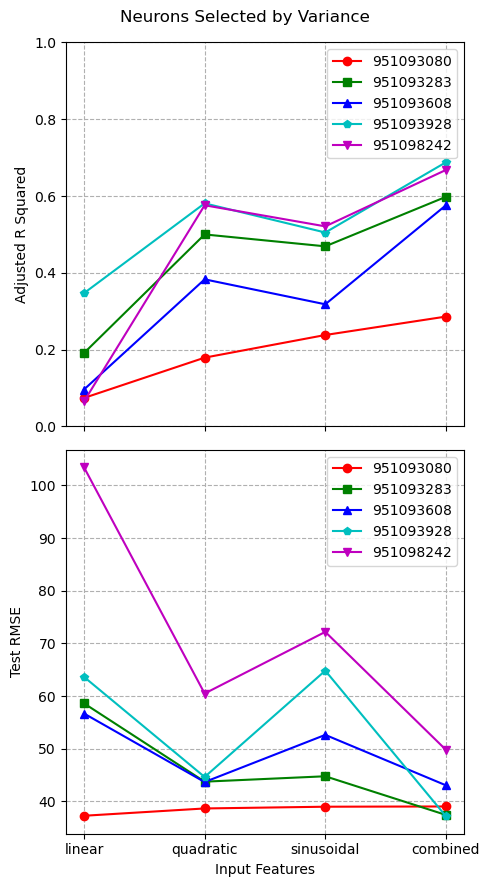

In [119]:
adjr2_neuron1 = [0.074, 0.179, 0.238, 0.286]
testloss_neuron1 = [37.292, 38.679, 39.010, 39.057]
adjr2_neuron2 = [0.191, 0.500, 0.469,0.598]
testloss_neuron2 = [58.628, 43.763, 44.787, 37.448]
adjr2_neuron3 = [0.096, 0.383, 0.318, 0.576]
testloss_neuron3 = [56.698, 43.695, 52.644, 43.070]
adjr2_neuron4 = [0.347, 0.581, 0.505, 0.688]
testloss_neuron4 = [63.649, 44.652, 64.832, 37.195]
adjr2_neuron5 = [0.065, 0.576, 0.521, 0.668]
testloss_neuron5 = [103.424, 60.493, 72.190, 49.803]
plot_stats_neurons(adjr2_neuron1, adjr2_neuron2, adjr2_neuron3, adjr2_neuron4, adjr2_neuron5,
                    testloss_neuron1, testloss_neuron2, testloss_neuron3, testloss_neuron4, testloss_neuron5,
                    title = "Variance", units = df["unit_id"].unique())